# Practical work on spectral estimation
### <ins>Report by: KHOUTAIBI Iliass and BARAKA Rayane</ins>

In this practical work, we propose to compare nonparametric spectral estimators (periodogram,
smoothed periodogram) with parametric estimators (linear prediction, Capon, Durbin methods), in the
case of three types of processes commonly encountered : autoregressive processes, sum of noisy sinu-
soids, and autoregressive-moving-average processes.

<ins style="color:orange">1. Autoregressive process</ins>

<strong>1.1 Synthesis</strong>
1. <ins style="color:orange">Code a function that synthesizes an autoregressive (AR) process of length N, defined by its AR
coefficients and the innovation variance σ2.</ins>

We shall start by importing important python libraries

In [74]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import librosa

We define a <strong>White noise</strong> function that returns a random variable following a standard normal distribution, we also define the AR process function, which returns an AR process of order p and of sepcified lenght.

In [75]:
# Here we have our white noise, a gaussian variable of mean 0 and varaince sigma2
def white_noise(mean,sigma,number_variables):
    """This Function here returns a White noise"""
    return np.random.normal(mean,sigma,number_variables)

#  Here we have the white AR sequence, built from an initial gaussian varaible
def AR(p,phis,sigma,number_variables):
    """This Function here returns an AR process"""
    # Initializing the random process
    AR_process = white_noise(0,sigma,number_variables)
    # Building the AR process recursively
    for variable in range(number_variables):
        for shift in range(p):
            AR_process[variable] += (phis[shift] * AR_process[variable-shift-1]) 
    return AR_process

We also define some Global Consts that we will be using throught the TP, namelt: SIGMA, PHIS, PHI and DEFAULT_NUMBER

In [76]:
PHIS = np.array([0.55,-0.7,0.3,0.1]) # Phis 
PHI = np.array([0.55]) # Phi
SIGMA = 1 # SIGMA default
DEFAULT_NUMBER = 1_000 # number of ariable by default

Let us plot and AR(1) process, with the DEFAULT_NUMBER of points.

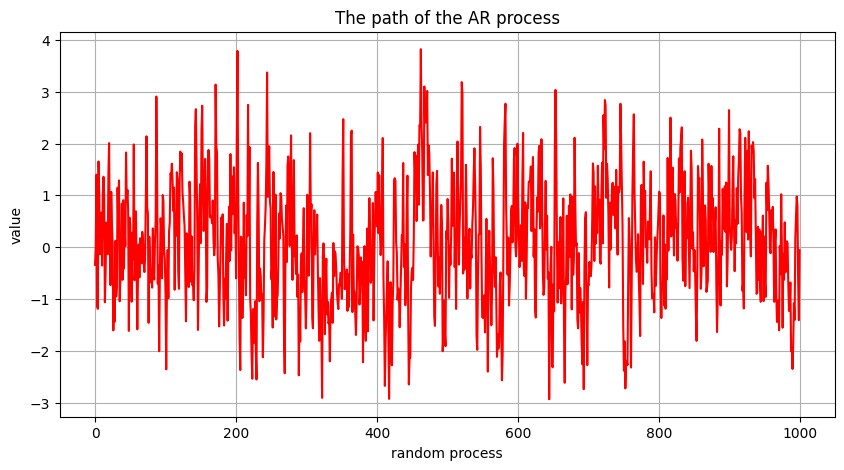

In [77]:
# AR_process for p = 1
AR_process = AR(1, PHI, SIGMA, DEFAULT_NUMBER)

plt.figure(figsize=(10,5))
plt.grid()
plt.plot(AR_process, color="red")
plt.xlabel('random process')
plt.ylabel('value')
plt.title("The path of the AR process")
plt.show()

<strong> 1.2 Non-parametric estimation : periodogram </strong>

2. <ins style="color : orange"> Code a function that computes and displays the periodogram of a given input signal, allowing to
choose between the standard method and the Bartlett and Welsh methods. </ins>

There are three methods of implementation asked to complete in this question, namely the <strong>Standard, Bartlett and the Welch</strong> Method.

- <strong>Standard</strong>:
The power spectral density in this case is approximated using the Fourier Trnasform of the signal, i.e: for $(X_k)_{k \in 0...N}$

$$S_{XX}(\nu) \approx \hat{S}_{XX}(\nu) = |\sum_{k=0}^{N} X_k e^{-2i\pi k\nu}|^2 $$

- <strong>Bartlett</strong>: The power spectral density is approximated by sampling the signal into $L$ subsamples, calculating the Power spectral density of each subsample and finally calculating the mean over them, i.e: for $M = \frac{N}{L}$

$$S_{XX}(\nu) \approx \hat{S}_{B, XX}(\nu) = \frac{1}{L} \sum_{j=1}^{L} \frac{1}{M} |\sum_{t = 1}^{M} \tilde{X}_{j,t} e^{-2i\pi \nu t}|^2 $$

- <strong>Welch</strong>: An improvement of the Bartlett Method, we segment the data and each segment get windows in order to reduce the Variance. 

for $t \in [1, M]$ and $i \in [1, S]$ : $\tilde{X}_{i,t} = X_{(i−1)K +t}$

if $K = M$, then we have the Bartlett Method : $S = L = \frac{N}{M}$.

We recommend taking $K = \frac{M}{2}$ and $S \approx \frac{2N}{M}$. 

$$\hat{S}_{W,XX} (\nu) = \frac{1}{S} \sum_{i=1}^{S} \hat{S}^{(i)}_{P,XX} (\nu)$$

Where $$\hat{S}^{(i)}_{P,XX} (\nu) = \frac{1}{MP} | \sum_{t=1}^{M} v (t) \tilde{X}_{i,t} e^{-2i\pi\nu t} |^2 $$

And $ P = \frac{1}{N} \sum_{t = 1}^{M} |v(t)|^2$

The code down below, is an implementation of the said Methods, apart from the Welch method, whose implementation in already included in the Scipy library and is better optimized.

In [78]:
def Bartlett(signal, L):
    """Compute the Bartlett periodogram estimate"""

    N = len(signal)
    assert L <= N
    M = N // L
    periodogram_inter = []

    for i in range(1, L + 1):  
        signal_inter = signal[(i-1) * M : (i-1) * M + M]  
        periodogram_inter.append(
            (1 / M) * pow(np.abs(np.fft.fft(signal_inter)), 2)  
        )

    return np.mean(periodogram_inter, axis = 0)  

def periodogram(signal, fs =1, L=5, method="Standard"):
    """Compute the periodogram using different methods
        Specifying the method specifies the method used
        We take L = 5 by default 
    """

    N = len(signal)

    if method == "Standard":
        result = (1 / N) * pow(np.abs(np.fft.fft(signal)), 2)
        f = np.fft.fftfreq(N, d=1/fs)
        f = np.fft.fftshift(f)
        result = np.fft.fftshift(result)
        return f, result

    elif method == "Bartlett":
        result = Bartlett(signal, L)
        f = np.fft.fftfreq(N//L, d=1/fs)
        f = np.fft.fftshift(f)
        result = np.fft.fftshift(result)
        return f , result

    elif method == "Welch":
        M = N // L
        f, result = sp.signal.welch(signal, fs=fs, nperseg=M, noverlap=M//2)
        result_two_sided = np.concatenate((result[-2:0:-1], result))  
        result_two_sided[1:-1] *= 0.5  
        n_freq = len(result)  # Number of one-sided frequencies
        f_full = np.fft.fftshift(np.fft.fftfreq(2 * n_freq - 2, d=1/fs))
        return f_full, result_two_sided

    else:
        raise ValueError("Please choose an appropriate method from: Standard, Bartlett, and Welch")


3. <ins style="color : orange">Display the periodograms obtained with the different methods (in dB), in the case of an AR process
of order 1 whose parameters can be chosen by hand. We will superimpose in each case the perio-
dogram with the known power spectral density (PSD) of the AR process. We will pay attention to
the correct normalization of the different estimators.</ins>

Let us first define a function that caulculates the power spectral density of an AR process.

In the special case where $X$ is an AR(p) process, we have that :  
$\begin{align}
        f(\lambda) = \sigma^2 \lvert\frac{1}{\Phi}(e^{-2\pi i\lambda})\lvert \nonumber\\ 
\end{align}$

and $$\Phi(X) = 1 - \sum_{k=1}^{p}\phi_{k}X^{k}$$

In [79]:
# Computing the Power spectral density of AR process
def spectral_density(nu,phis,sigma):
    # Calculating the Polynopial in the denominator 
    p = len(phis)
    phi_sum = 1.0  
    for k in range(p):
        phi_sum -= phis[k] * np.exp(-2j*np.pi*nu*(k + 1))
    # denominator
    denom = np.abs(phi_sum) ** 2
    # Return PSD
    return (sigma**2) / denom

Let us plot the Periodograms of the different methods and the real power spectral density of the previosly defined AR(1) process.

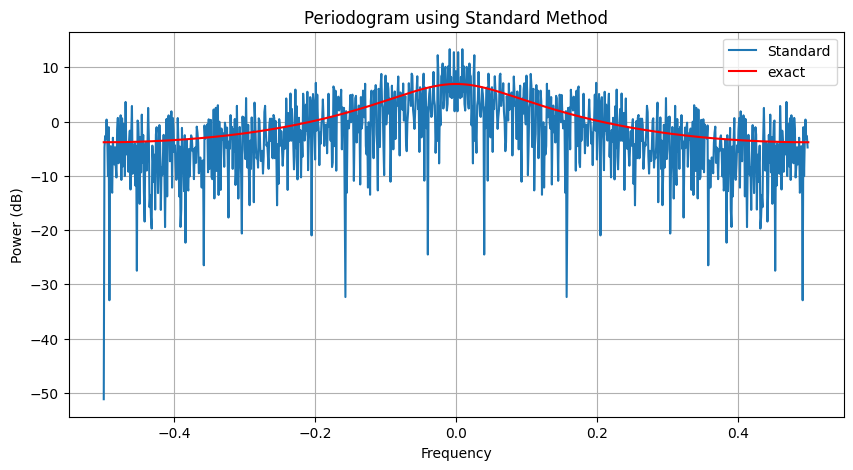

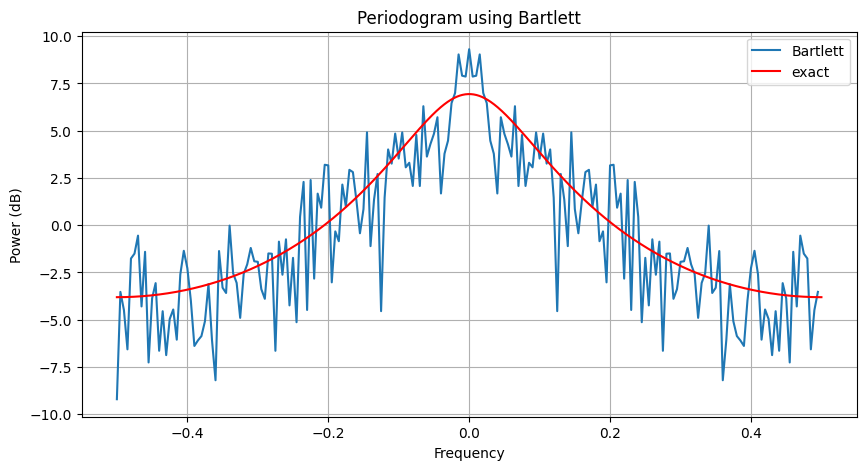

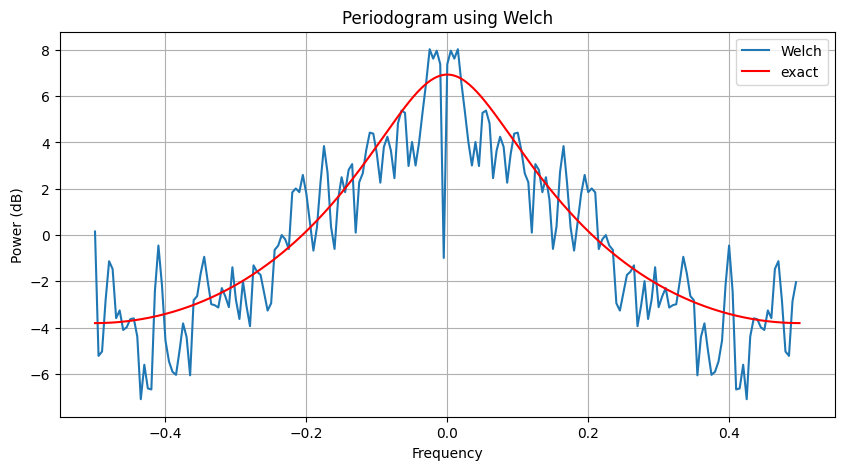

In [80]:
# Getting the periodogram of the AR(1) process for different methods
f, periodogram_standard = periodogram(signal=AR_process, method="Standard")
f_bartlett, Bartlett_periodogram = periodogram(signal=AR_process, method="Bartlett")
f_welch, Welch_periodogram = periodogram(signal=AR_process, method="Welch")

# spectra on -1/2, 1/2 and the exact power spectral density
nu_demi = np.linspace(-1/2, 1/2, DEFAULT_NUMBER)
theoritical_spectral = spectral_density(nu_demi, PHI, SIGMA)

# Plotting the Graph
plt.figure(figsize=(10,5))
plt.plot(f, 10*np.log10(periodogram_standard), label="Standard")
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact",color='red')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Standard Method")
plt.grid()

plt.figure(figsize=(10,5))
plt.plot(f_bartlett, 10*np.log10(Bartlett_periodogram), label="Bartlett")
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact", color='red')
plt.grid()
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Bartlett")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(f_welch, 10*np.log10(Welch_periodogram), label="Welch")
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact",color='red')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Welch")
plt.grid()
plt.show()


We get interesting results, the estimators follow the path of the exact power spectral density of the AR(1) process, but we of course have a lot of variance. However, both the <strong>Bartlett</strong> and the <strong>Welch</strong> have reduced variance compared to the <strong>Standard</strong> method. We also notice that the <strong>Welch</strong> method has apparent bias !

4. <ins style="color : orange">Experimentally compare these different estimators in terms of bias and variance.</ins>

The bias of the different estimators is defined as :

$$ \text{bias} = \mathbb{E}(\hat{S}_{XX} (\nu)) - S_{XX}(\nu) $$

The variance is the usual definition of the Variance of a signal.

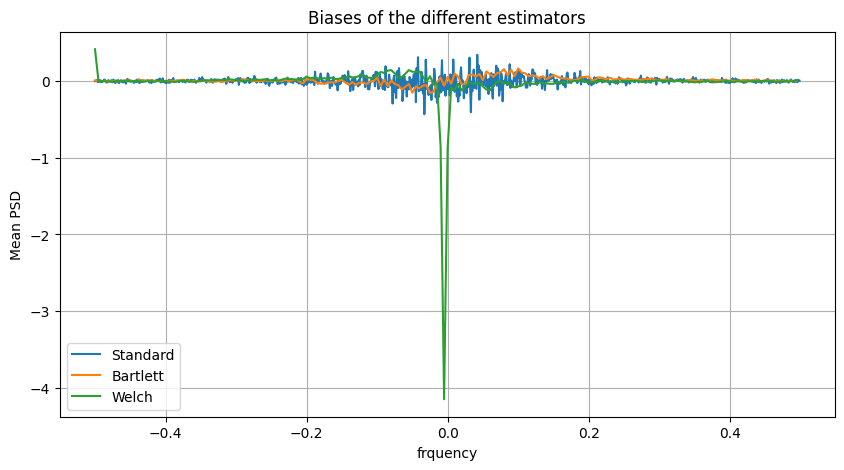

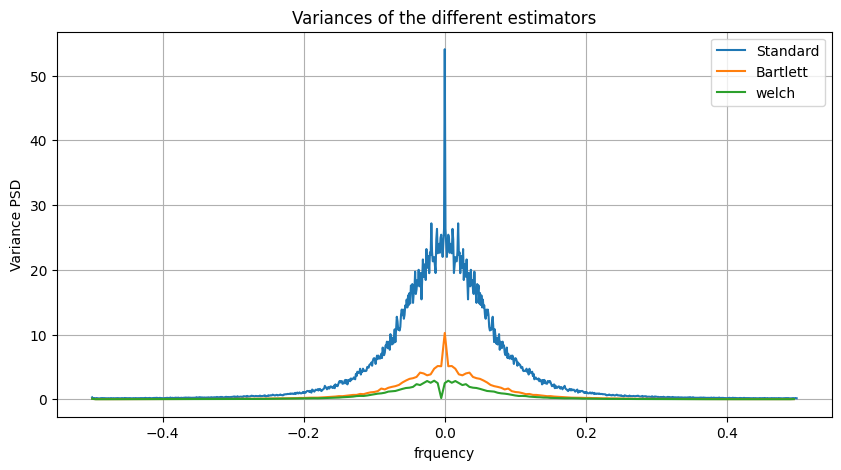

In [81]:
def bias_var_calculator_AR(p, phis, sigma, numebr_variables, method):
    """ Bias and Variance Caluclator for the periodogram of an AR process
        We generate 1000 AR processes and then calaculate the meanS of the periodogram for the specified method
    """
    
    number_tests = 1_000
    AR_process = AR(p, phis, sigma, numebr_variables)
    f, _ = periodogram(AR_process, method=method)
    periodogram_list = np.zeros((DEFAULT_NUMBER, len(f)))
    nus = np.linspace(-1/2, 1/2, len(f))
    theoritical_density = spectral_density(nus, phis, sigma)

    for i in range(number_tests):
        AR_process = AR(p, phis, sigma, numebr_variables)
        _, periodogram_inter = periodogram(AR_process, method=method)
        periodogram_list[i, :] = periodogram_inter

    mean_process = np.mean(periodogram_list, axis=0)
    bias_process = mean_process - theoritical_density
    var_process = np.var(periodogram_list, axis=0)
    
    return mean_process, bias_process, var_process


_, bias_standard, var_standard = bias_var_calculator_AR(1, PHI, SIGMA, DEFAULT_NUMBER, method="Standard")
_, bias_barlett, var_barlett = bias_var_calculator_AR(1, PHI, SIGMA, DEFAULT_NUMBER, method="Bartlett")
_, bias_welch, var_welch = bias_var_calculator_AR(1, PHI, SIGMA, DEFAULT_NUMBER, method="Welch")


plt.figure(figsize=(10,5))
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f, bias_standard, label="Standard")
plt.plot(f_bartlett, bias_barlett, label="Bartlett")
plt.plot(f_welch, bias_welch, label = "Welch")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f, var_standard, label="Standard")
plt.plot(f_bartlett, var_barlett, label="Bartlett")
plt.plot(f_welch, var_welch, label="welch")
plt.legend()
plt.show()

As we can see, the different estimators are unbiased, The <strong> Standard </strong> estimator is the one with the most variance, with the two other methods having the same variance, which corresponds with the courses Theorems.

<strong>1.3 Parametric estimation : linear prediction</strong>

5. <ins style="color : orange">Estimate the AR model using either the code you wrote in the previous practical work of TSIA202a,
or the function lpc (linear prediction method) from Matlab or from the librosa Python package.</ins>

We shall reuse the function already coded in the TSIA202a Practical works, since they give good results. As explained in the previous practical works, estimating the AR processes coefficient is solving the Yule-Walker equations, as is :

$\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma^{2} \; 0 \; \ldots \; 0]^T \nonumber 
\end{equation}$

With 

$$ \Gamma_{p+1} = 	\begin{bmatrix}
                    \gamma(0) & \gamma(-1) & ... & \gamma(-p)    \\
                    \gamma(-1) & \gamma(0)  & ... & \gamma(1-p)   \\
                    .       &     .      &  .     &      .       \\
                    .       &     .      &  .     &      .       \\
                    .       &     .      &  .     &      .       \\
                    \gamma(-p) & \gamma(1-p)& ... & \gamma(0)
\end{bmatrix} $$

And $\gamma$ the autocovariance variance of the signal.

The cells down below, are an implementation of this solution. We define a function that calculates the mean of the signal and another one that calculates the Empirical Autocovariance for $k$ points.

In [82]:
# Computing the empirical mean of the random varaibles
def empirical_mean(X):
    assert(len(X) != 0)
    return np.mean(X)

# Computing the empirical autocovaraince of the random process
def empirical_autocovariance(X, taus):
    # Initializing the lenght and the tau matrix
    N = len(X)
    X_sum = np.zeros(len(taus))    
    # Computing the autocovaraince
    for tau, k in enumerate(taus):
        X_shifted = X[k:N] - empirical_mean(X)
        X_original = X[0:N-k] - empirical_mean(X)
        X_sum[tau] = (1/N)  * np.sum(X_shifted * X_original)
    
    return X_sum   

The cell down below solves the Yule-Walker equation and returns the $\Gamma_{p+1}$ Matrix, the approximated $\sigma$ and finally the approximated coefficients $\phi$.

In [83]:
def Gamma(p, signal):

    # Initializing the i,js of the matrix
    taus = np.arange(0,p+1)
    # Computing the empirical autocovaraince 
    empirical_autocov = empirical_autocovariance(signal,taus=taus)
    # Generating the Toeplitz Gamma(p+1) matrix using scipy  
    gamma = sp.linalg.toeplitz(empirical_autocov)
    
    # Approximating the phis and the sigma2

    # Computing the [1/sigma2, phi1/sigm2 , ... , phip/sigm2] using the equation(1)
    approximation = np.linalg.inv(gamma) @ np.array([1 if v == 0 else 0 for v in range(p+1)]).T

    # Computing the sigma2 and the phi coefficients 
    sigma_approximation_square = 1/approximation[0]
    empirical_phis = -(sigma_approximation_square*approximation[1:])
    sigma_approximation = np.sqrt(sigma_approximation_square)
    
    # Returning the matrix, the sigma2 and the empirical phis
    return gamma , sigma_approximation , empirical_phis

the Gamma matrix is :
 [[1.4597769  0.79051392]
 [0.79051392 1.4597769 ]]

the approximated phis are: [0.54153064] while the initial phis are: [0.55] 

the approximated sigma is: 1.0157211213451895 while the initial sigma is: 1



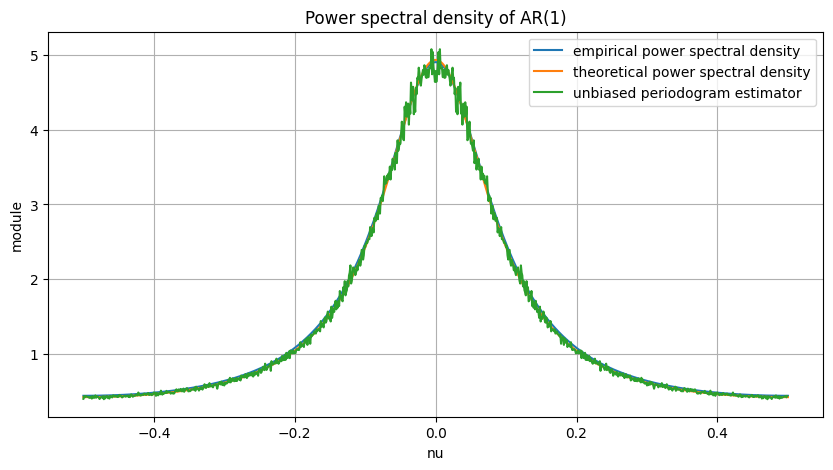

In [84]:
# Computing the empirical and theoritical spectral densities
AR_process = AR(1, PHI, SIGMA, DEFAULT_NUMBER)
gamma_1 , sigma_approximation , empirical_phis = Gamma(1, AR_process)

print(f"the Gamma matrix is :\n {gamma_1}\n")
print(f"the approximated phis are: {empirical_phis} while the initial phis are: {PHI} \n")
print(f"the approximated sigma is: {sigma_approximation} while the initial sigma is: {SIGMA}\n")

empirical_spectral = spectral_density(nu_demi, empirical_phis, sigma_approximation)
theoritical_spectral = spectral_density(nu_demi, PHI, SIGMA)
mean_standard, _, _ = bias_var_calculator_AR(1, PHI, SIGMA, DEFAULT_NUMBER, method="Standard")

# Plotting the spectral density using the roots method
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nu_demi, empirical_spectral)
plt.plot(nu_demi, theoritical_spectral)
plt.plot(f, mean_standard)
plt.xlabel("nu")
plt.ylabel("module")
plt.title("Power spectral density of AR(1)")
plt.legend(["empirical power spectral density","theoretical power spectral density", "unbiased periodogram estimator"])
plt.show()

As we can see, we get good approximation of the $\phi$ coefficients, as well as a ood approximation of the deviation $\sigma$, we also notice a good approximation of the power spectral density of the signal. Overall, we have a good way to approximate the Power spectral density but with a lot of variance.

<strong>1.4 Application to speech signals</strong>  

7. <ins style="color : orange">Apply the above methods to a vowel sound (such as ’a’ for example, that we can extract from
file aeiou.wav, downloadable from the eCampus website of TSIA202b), and superimpose the
estimated spectra. Comment. </ins>

Let us extract the 'a' vowel for example, in the sound file, the vowel is situated at $[0, 1]$ seconds. So we will generate the sound file and slice the sound file accordignly.

Let us aog a bit further, and try approximating 'a' with an <strong>AR(200) Process </strong> !

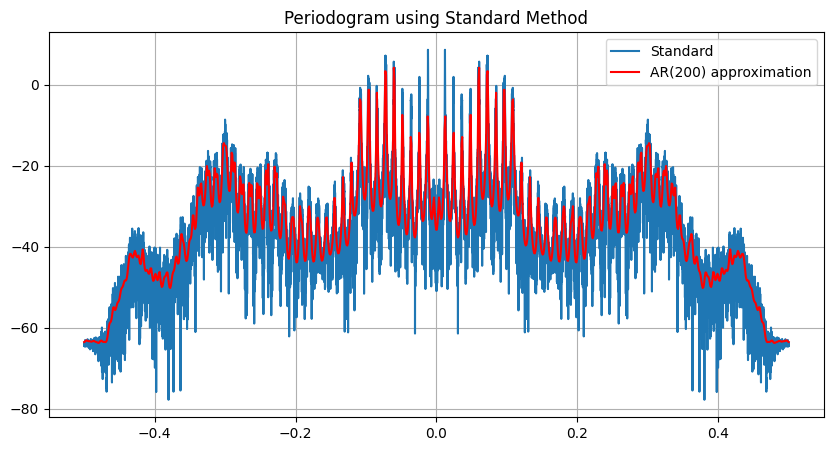

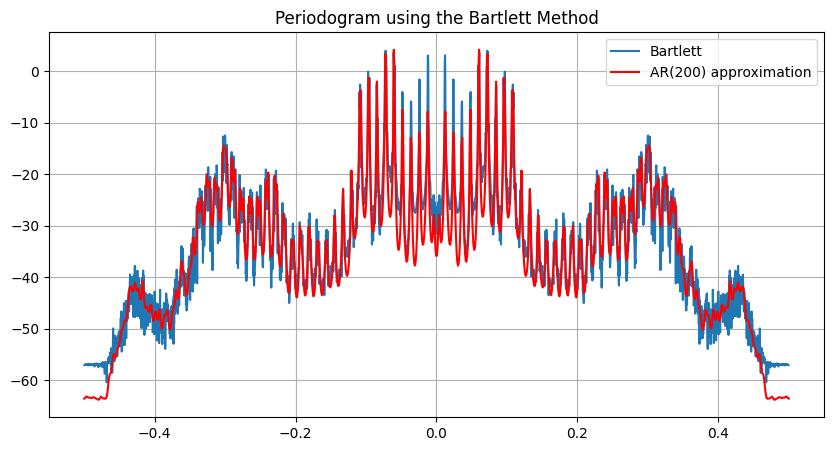

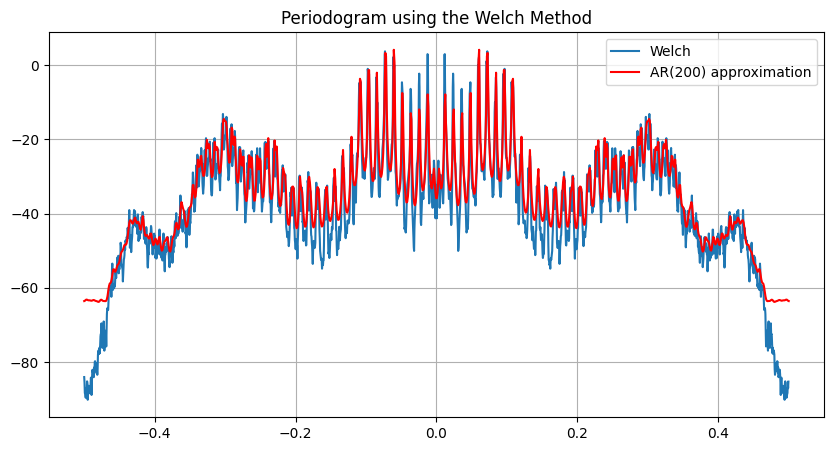

In [85]:
x, sr = librosa.load("aeiou.wav", sr=None)
# Extracting the 'a' Vowel
start_time = 0.0
end_time = 1.0

# Periodogram
x_aaaa = x[int(start_time*sr) : int(end_time*sr)]
f_aeiou, standard = periodogram(x_aaaa, method="Standard")
f_aeiou_bartlett, bartlett = periodogram(x_aaaa, method="Bartlett")
f_aeiou_welch, welch = periodogram(x_aaaa, method="Welch")

# Estimating an AR(200) process ! 
_, sigma_approximation , phi_estimates = Gamma(200, x_aaaa)
spectral_density_aaa = spectral_density(nu_demi, phi_estimates, sigma_approximation)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(f_aeiou, 10*np.log10(standard), label="Standard")
plt.plot(nu_demi, 10*np.log10(spectral_density_aaa), color="red",label="AR(200) approximation")
plt.title("Periodogram using Standard Method")
plt.grid()
plt.legend()


plt.figure(figsize=(10, 5))
plt.title("Periodogram using the Bartlett Method")
plt.plot(f_aeiou_bartlett, 10*np.log10(bartlett), label="Bartlett")
plt.plot(nu_demi, 10*np.log10(spectral_density_aaa), color="red",label="AR(200) approximation")
plt.legend()
plt.grid()


plt.figure(figsize=(10, 5))
plt.title("Periodogram using the Welch Method")
plt.plot(f_aeiou_welch, 10*np.log10(welch), label="Welch")
plt.plot(nu_demi, 10*np.log10(spectral_density_aaa), color="red",label="AR(200) approximation")
plt.grid()
plt.legend()
plt.show()


As we can see, we get a great reconstruction of the 'a' Vowel using the AR(200) approximation, which makes sense ! 

Saying 'a' only moves slight Pharync muscles, so at instance $t$, the 'a' sound only depends of the previous 'a' sounds. We can also add a small white noise, which represents the spasms of the muscles and such.

<strong> 2 Sum of noisy sinusoids </strong>  

<strong>2.1 Synthesis</strong>

1. <ins style="color:orange"> Code a function that synthesizes a signal of length N, consisting of the sum of K real sinusoids
defined by their frequencies, amplitudes and origin phases, and a Gaussian white noise of variance
σ2.</ins>

The signal $S$ that we shall synthesis is as follows:

$$S(f, t) = \sum_{k=0}^{K} \sin(2\pi k\frac{f}{f_s}t) + Z_{t}$$ 

With 

$$ Z \sim WN(0 , \sigma^2)$$

And $f_s$ the sampling rate of our signal.

In [86]:
def sinusoidal(Amplitudes, frequencies, fs, timesteps, phases, sigma):
    """Generate a sum of K sinusoids plus white noise"""

    K = len(frequencies)
    Z = white_noise(0, sigma, number_variables=(len(timesteps)))
    y = np.zeros((len(timesteps),K))
    
    for i in range(K):
        y[:, i] = Amplitudes[i] * np.sin(2* np.pi * (frequencies[i]/fs) * timesteps + phases[i])
    
    return np.sum(y, axis=1) + Z

<strong>2.2 Non parametric estimation : periodogram</strong>

2. <ins style="color:orange"> Display the periodograms obtained with the standard method and the Bartlett and Welsh methods,
in the case of K = 2 sinusoidal frequencies ν1 and ν2, zero origin phase and same amplitude
equal to 1. We will superimpose in each case the periodogram with two vertical lines centered at
frequencies ν1 and ν2, and a horizontal line centered at the variance σ2. </ins>

This is a long quesiton, so in order to make things efficient, we shall code a function that plots the Power Spectral Density of the sinusoidal signal using the different methods studied before.

In [87]:
def plotting_sinusoidals(sinusoidal_signal, nus, fs, sigma=SIGMA):
    """ Function to plot sinusoidals, used to automate the processis istead of plotting each time"""

    f, standard_sinusoidal = periodogram(sinusoidal_signal, fs=fs)
    f_bartlett , bartlett_sinusoidal = periodogram(sinusoidal_signal, method = "Bartlett", fs=fs)
    f_welch, welch_sinusoidal = periodogram(sinusoidal_signal, method="Welch", fs=fs)
    mean_welch = np.mean(welch_sinusoidal)
    mean_bartlett = np.mean(bartlett_sinusoidal)
    mean_standard = np.mean(standard_sinusoidal)

    fig, ax = plt.subplots(2, 2, figsize=(15,7))
    fig.suptitle(
        rf"Resolution for $|\Delta(\nu_{1} - \nu_{2})|$={np.abs(nus[1] - nus[0])}"
    )
    fig.delaxes(ax[1,1])

    ax[0,0].grid()
    ax[0,0].set_xlabel("frequencies")
    ax[0,0].set_ylabel("Amplitude")
    ax[0,0].plot(f_welch, 10*np.log10(welch_sinusoidal))
    ax[0,0].set_title("Periodogram of sinusoid with Welch")
    ax[0,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,0].axhline(mean_welch, color="purple", label=r"$\mu$")
    ax[0,0].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[0,0].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,0].legend()

    ax[0,1].plot(f_bartlett, 10*np.log10(bartlett_sinusoidal))
    ax[0,1].set_title("Periodogram of sinusoid using Bartlett")
    ax[0,1].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,1].axhline(mean_bartlett, color="purple", label=r"$\mu$")
    ax[0,1].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[0,1].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,1].grid()
    ax[0,1].legend()

    ax[1,0].plot(f, 10*np.log10(standard_sinusoidal))
    ax[1,0].set_title("Periodogram of sinusoid using Standard")
    ax[1,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[1,0].axhline(mean_standard, color="purple", label=r"$\mu$")
    ax[1,0].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[1,0].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[1,0].grid()
    ax[1,0].legend()

    plt.show()

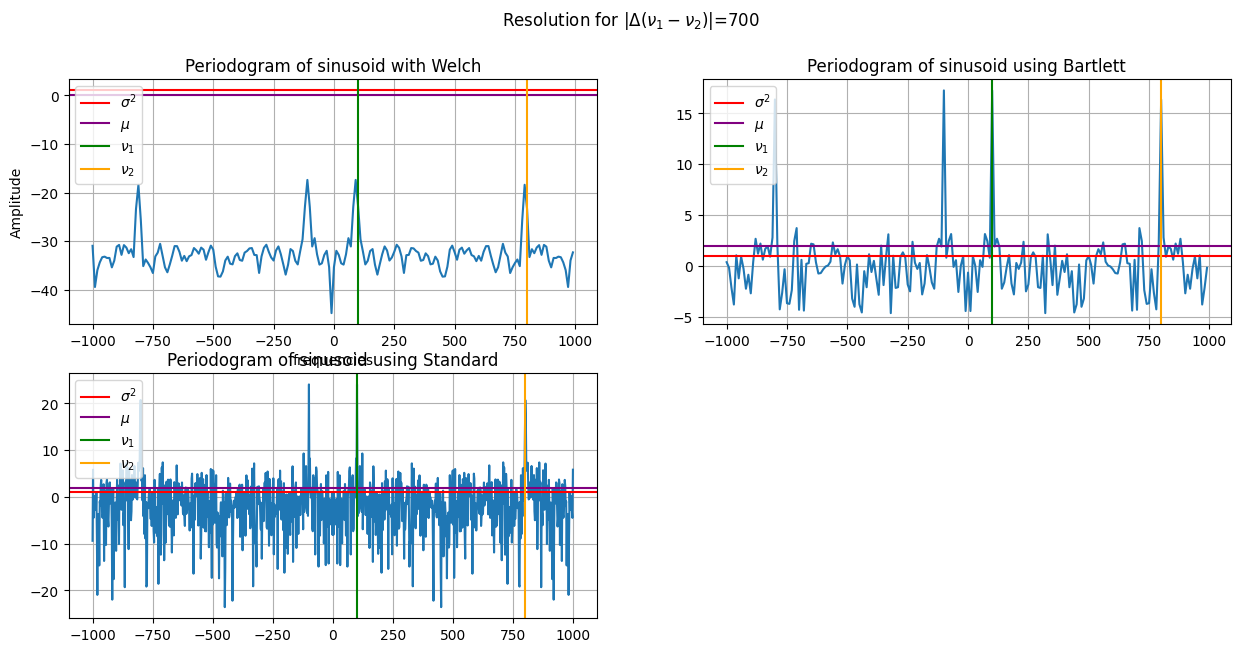

In [88]:
# defining nu1, nu2, the amplitudes, the sampling rate, the amplitudes and the phases.
nu_1_2 = [100, 800]
Fs = 2 * DEFAULT_NUMBER
amplitudes = [1, 1]
timesteps = np.linspace(0, DEFAULT_NUMBER, DEFAULT_NUMBER)
phases = np.zeros(2)

signal_sinousial = sinusoidal(amplitudes, nu_1_2, Fs, timesteps, phases, SIGMA)
plotting_sinusoidals(signal_sinousial, nu_1_2, Fs, SIGMA)

We can see that the resolution of the <strong>Standard</strong> method has the worst resolution because of its high variance. Both the <strong>Bartlett and the Welch</strong> methods have good resolution thanks to their low variance.

3. <ins style="color:orange">Compare the resolution of the various periodograms, by varying the difference ∆ν = |ν1 − ν2|
between both frequencies, as well as the signal-to-noise ratio (SNR) in dB. </ins>

We shall define a function to compute the <strong>SNR</strong> of a signal and plotting the resolution of each methods for the signal.

In [89]:
def SNR(signal, noise):
    """ Function that computes the SNR of a signal"""
    
    P_signal = np.mean(pow(signal, 2))
    P_noise = np.mean(pow(noise, 2))

    SNR_dB = 10 * np.log10(P_signal / P_noise)
    return SNR_dB 

Here we will varry the $\nu_{2}$ frequency from $100$ to $800$, while keeping $\nu_{1}$ fixed at $100$.

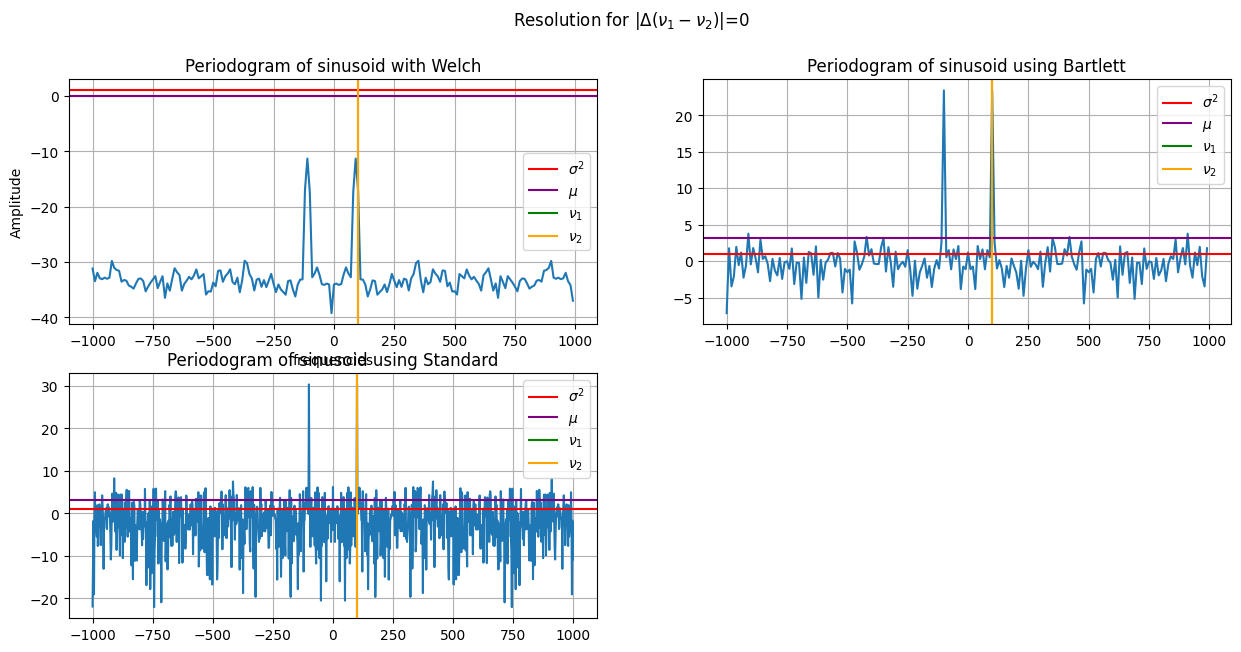

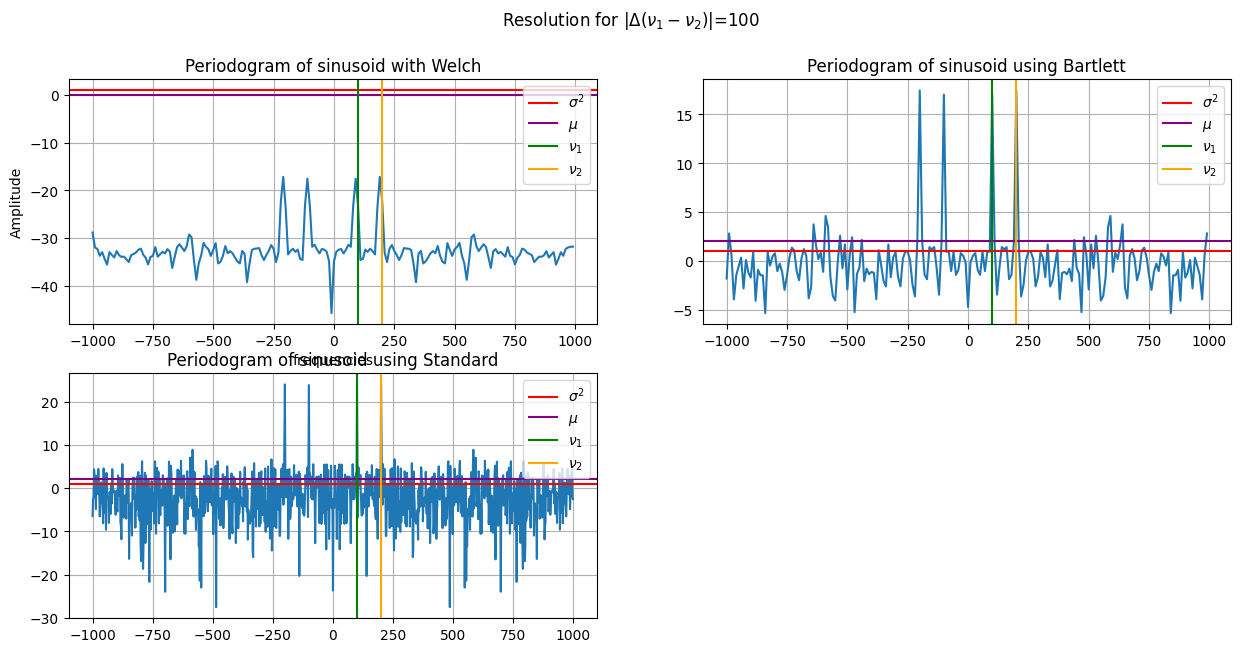

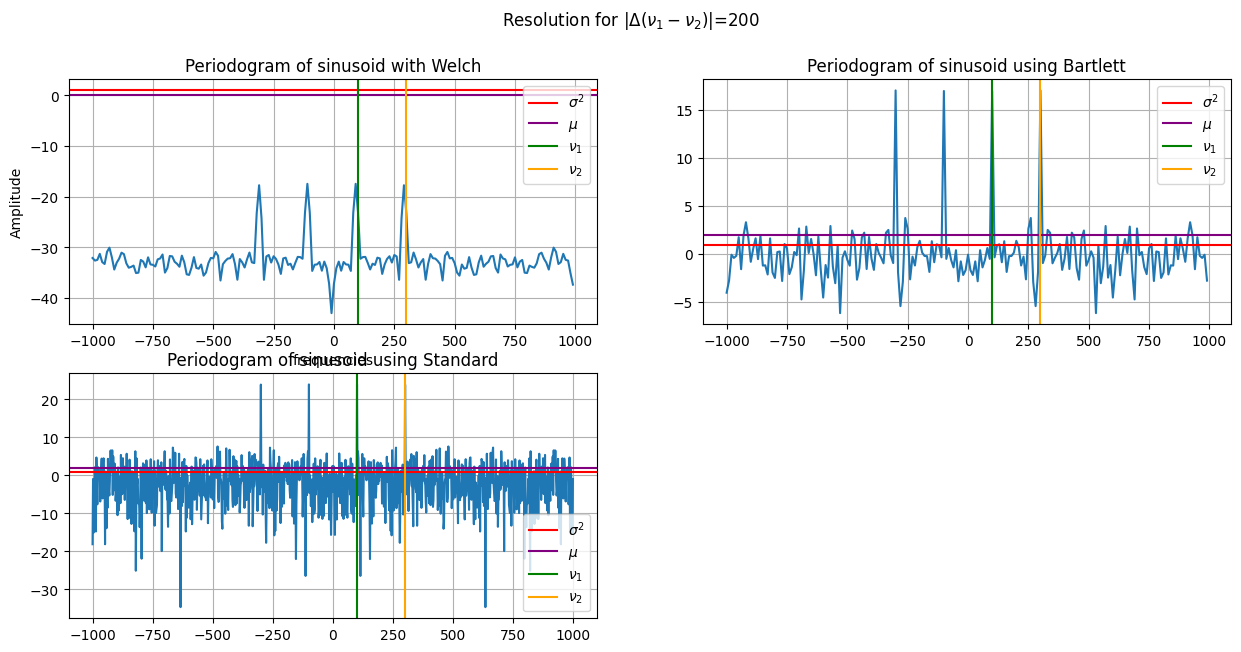

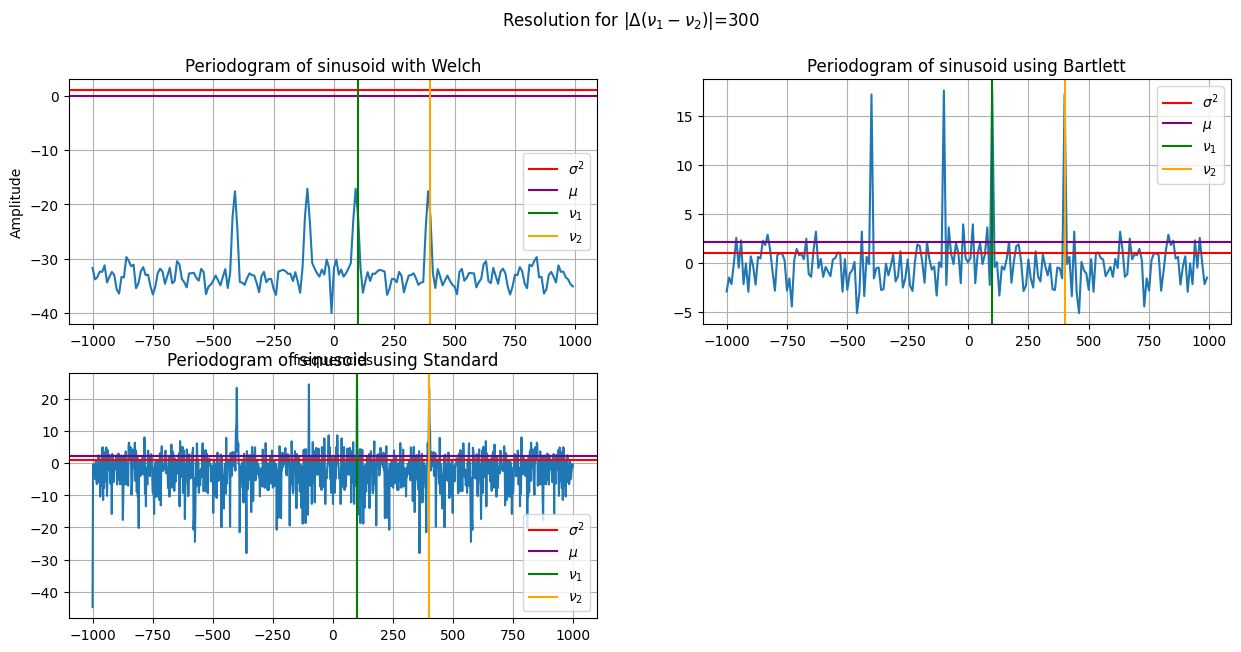

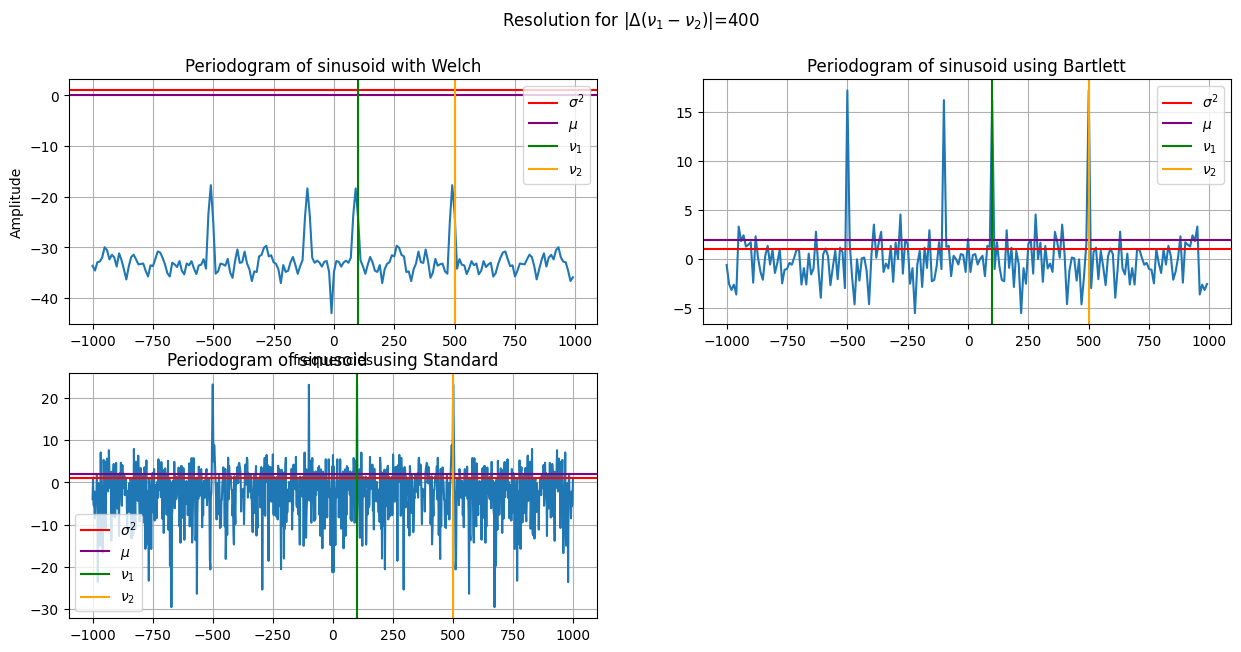

The SNR for |nu_1 - nu_2| = 0 is: 4.929974348470109
The SNR for |nu_1 - nu_2| = 100 is: 2.9716105405224535
The SNR for |nu_1 - nu_2| = 200 is: 2.91894356783678
The SNR for |nu_1 - nu_2| = 300 is: 3.0951161560143587
The SNR for |nu_1 - nu_2| = 400 is: 2.774019401407904


In [90]:
# Getting the frequencies, phis, amplitudes, Fs and timesteps
nu_1 = 100 #Hz
nu_2 = np.arange(100, 600, 100) #Hz
Fs = 2 * DEFAULT_NUMBER
amplitudes = [1, 1]
timesteps = np.linspace(0, DEFAULT_NUMBER, DEFAULT_NUMBER)
phases = np.zeros(2)
Z = white_noise(0, SIGMA, DEFAULT_NUMBER)
snr = []

# Plotting the results
for i in nu_2:
    nus_1_2 = [nu_1, i]
    signal_sinousial = sinusoidal(
        amplitudes, nus_1_2, Fs, timesteps, phases, SIGMA
    )
    plotting_sinusoidals(signal_sinousial, nus_1_2, Fs, SIGMA)
    snr.append(SNR(signal_sinousial, Z))

for j in range(len(nu_2)):
    print(f"The SNR for |nu_1 - nu_2| = {np.abs(nu_2[j] - nu_1)} is: {snr[j]}")

We can see that SNR of the signal decreases the more we increase the gap between the main frequencies of the sinusoidal. We can also affirm that the resolution of both <strong>Welch and Bartlett</strong> methods have better resolution compared to the <strong>Standard</strong> method.

<strong>2.3 Parametric estimation : linear prediction </strong>

4. <ins style="color : orange">Estimate a fourth order AR model using the linear prediction method.</ins>

Let us first generate an AR(4) process using the previously defined constants. We will compute an $\text{AR}(4)$ process to make things more interesting.

In [91]:
AR_process_4 = AR(4, PHIS, SIGMA, DEFAULT_NUMBER)

the Gamma matrix is :
 [[ 2.08146687  0.46562676 -1.13265519 -0.25423487  1.00423022]
 [ 0.46562676  2.08146687  0.46562676 -1.13265519 -0.25423487]
 [-1.13265519  0.46562676  2.08146687  0.46562676 -1.13265519]
 [-0.25423487 -1.13265519  0.46562676  2.08146687  0.46562676]
 [ 1.00423022 -0.25423487 -1.13265519  0.46562676  2.08146687]]

the approximated phis are: [ 0.55361856 -0.67278648  0.30365885  0.11604921] while the initial phis are: [ 0.55 -0.7   0.3   0.1 ] 

the approximated sigma is: 1.0110948034966891 while the initial sigma is: 1



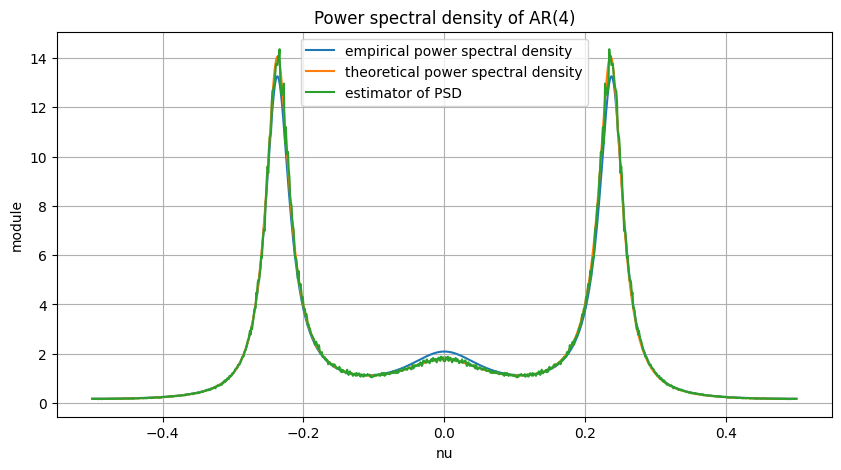

In [92]:
# Approximating the coefficients and sigma
gamma_4 , sigma_approximation , empirical_phis = Gamma(4, AR_process_4)

print(f"the Gamma matrix is :\n {gamma_4}\n")
print(f"the approximated phis are: {empirical_phis} while the initial phis are: {PHIS} \n")
print(f"the approximated sigma is: {sigma_approximation} while the initial sigma is: {SIGMA}\n")

mean_standard_4, _, _ = bias_var_calculator_AR(4, PHIS, SIGMA, DEFAULT_NUMBER, method="Standard")
theoritical_spectral = spectral_density(nu_demi, PHIS, SIGMA)
empirical_spectral = spectral_density(nu_demi, empirical_phis, sigma_approximation)

# Plotting the spectral density using the roots method
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nu_demi, empirical_spectral)
plt.plot(f, theoritical_spectral)
plt.plot(f, mean_standard_4)
plt.xlabel("nu")
plt.ylabel("module")
plt.title("Power spectral density of AR(4)")
plt.legend(["empirical power spectral density","theoretical power spectral density", "estimator of PSD"])
plt.show()


We can see an exact match betwen the theoretical, the estimated and the empirical PSD of our proccess!

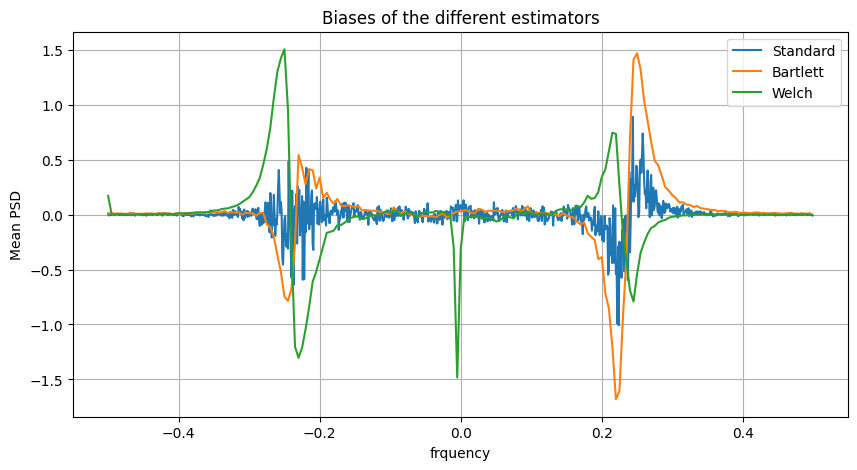

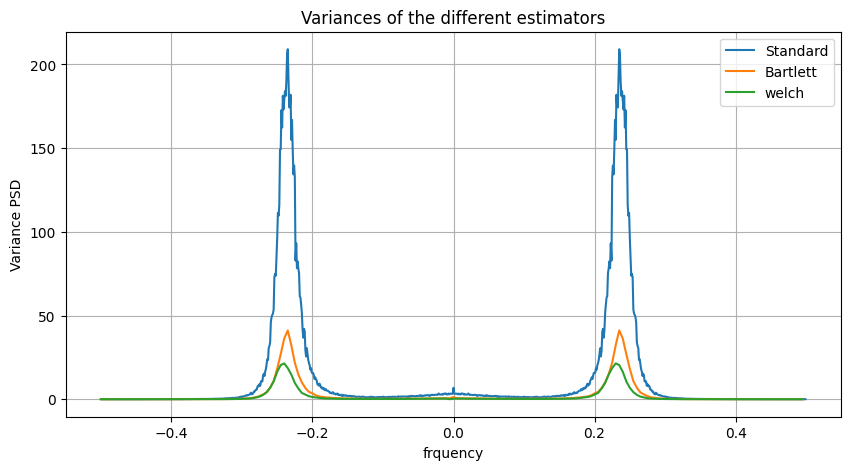

In [93]:
_, bias_standard, var_standard = bias_var_calculator_AR(4, PHIS, SIGMA, DEFAULT_NUMBER, method="Standard")
_, bias_barlett, var_barlett = bias_var_calculator_AR(4, PHIS, SIGMA, DEFAULT_NUMBER, method="Bartlett")
_, bias_welch, var_welch = bias_var_calculator_AR(4, PHIS, SIGMA, DEFAULT_NUMBER, method="Welch")


plt.figure(figsize=(10, 5))
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f, bias_standard, label="Standard")
plt.plot(f_bartlett, bias_barlett, label="Bartlett")
plt.plot(f_welch, bias_welch, label = "Welch")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f, var_standard, label="Standard")
plt.plot(f_bartlett, var_barlett, label="Bartlett")
plt.plot(f_welch, var_welch, label="welch")
plt.legend()
plt.show()

<strong> 2.4 Parametric estimation : Capon estimator </strong>

6. <ins style="color : orange">Code a function that implements the Capon estimator. </ins>

The capon estimator is defined as :

$$ \hat{S}_{CAP, XX} (ν) = \frac{N}{e(\nu)^{H} R_{XX}^{-1} e(\nu)}$$

With $$R_{XX} = \mathbb{E}[XX^{H}], e(\nu) = [1, e^{2i\pi \nu}, ...,e^{2i\pi (N-1)\nu}]$$

First, because of the high complexity of Matrix inversion, we shall inverse it once, in the following cell.

In [94]:
# Getting the autocovariance Matrix and Inversing it
taus = np.arange(0, DEFAULT_NUMBER)
empirical_autocov = empirical_autocovariance(signal_sinousial,taus=taus)
R_xx = sp.linalg.toeplitz(empirical_autocov)
inverse = np.linalg.inv(R_xx)

The Function down below computes the Capon estimator for a frequency $\nu$

In [95]:
def Capon(nu, R_XX_inverse, number_variables):
    # Generating the Toeplitz Gamma(p+1) matrix using scipy  
    taus = np.arange(0, number_variables)
    e_nu = np.exp(2j * np.pi * nu * taus)
    e_nu_hat = np.conj(e_nu).T

    return number_variables / (e_nu_hat @ R_XX_inverse @ e_nu)

7. <ins style="color : orange">Compare the resolution of this method with the two previous methods, always by varying ∆ν, as
well as the SNR in dB. </ins>

Like before, we shall define a function that will make the plotting much easier.

In [96]:
def plotting_sinusoidals_Capon(sinusoidal_signal, nus_sinus, nus, fs, sigma=SIGMA):
    """ Function to plot sinusoidals, used to automate the processis istead of plotting each time"""

    result_capon = np.zeros(len(signal_sinousial))
    empirical_autocov = empirical_autocovariance(signal_sinousial,taus=taus)
    R_xx = sp.linalg.toeplitz(empirical_autocov)
    N = len(signal_sinousial)
    inverse = np.linalg.inv(R_xx)     
    
    for i in range(N):
        capon_instance = Capon(nus[i], inverse, N)
        result_capon[i] = pow(np.abs(capon_instance), 2)
        
    f_bartlett , bartlett_sinusoidal = periodogram(sinusoidal_signal, method = "Bartlett", fs=fs)
    f_welch, welch_sinusoidal = periodogram(sinusoidal_signal, method="Welch", fs=fs)
    mean_welch = np.mean(welch_sinusoidal)
    mean_bartlett = np.mean(bartlett_sinusoidal)
    mean_capon = np.mean(result_capon)

    fig, ax = plt.subplots(2, 2, figsize=(15,7))
    fig.suptitle(
        rf"Resolution for $|\Delta(\nu_{1} - \nu_{2})|$={np.abs(nus_sinus[1] - nus_sinus[0])}"
    )
    fig.delaxes(ax[1,1])

    ax[0,0].grid()
    ax[0,0].set_xlabel("frequencies")
    ax[0,0].set_ylabel("Amplitude")
    ax[0,0].plot(f_welch, 10*np.log10(welch_sinusoidal))
    ax[0,0].set_title("Periodogram of sinusoid with Welch")
    ax[0,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,0].axhline(mean_welch, color="purple", label=r"$\mu$")
    ax[0,0].axvline(nus_sinus[0], color="green", label=r"$\nu_{1}$")
    ax[0,0].axvline(nus_sinus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,0].legend()

    ax[0,1].plot(f_bartlett, 10*np.log10(bartlett_sinusoidal))
    ax[0,1].set_title("Periodogram of sinusoid using Bartlett")
    ax[0,1].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,1].axhline(mean_bartlett, color="purple", label=r"$\mu$")
    ax[0,1].axvline(nus_sinus[0], color="green", label=r"$\nu_{1}$")
    ax[0,1].axvline(nus_sinus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,1].grid()
    ax[0,1].legend()

    ax[1,0].plot(nus * fs, 10*np.log10(result_capon))
    ax[1,0].set_title("Periodogram of sinusoid using Capon")
    ax[1,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[1,0].axhline(mean_capon, color="purple", label=r"$\mu$")
    ax[1,0].axvline(nus_sinus[0], color="green", label=r"$\nu_{1}$")
    ax[1,0].axvline(nus_sinus[1], color="orange", label=r"$\nu_{2}$")
    ax[1,0].grid()
    ax[1,0].legend()

    plt.show()

Now we can start comparing the Resolution of the Methdods.

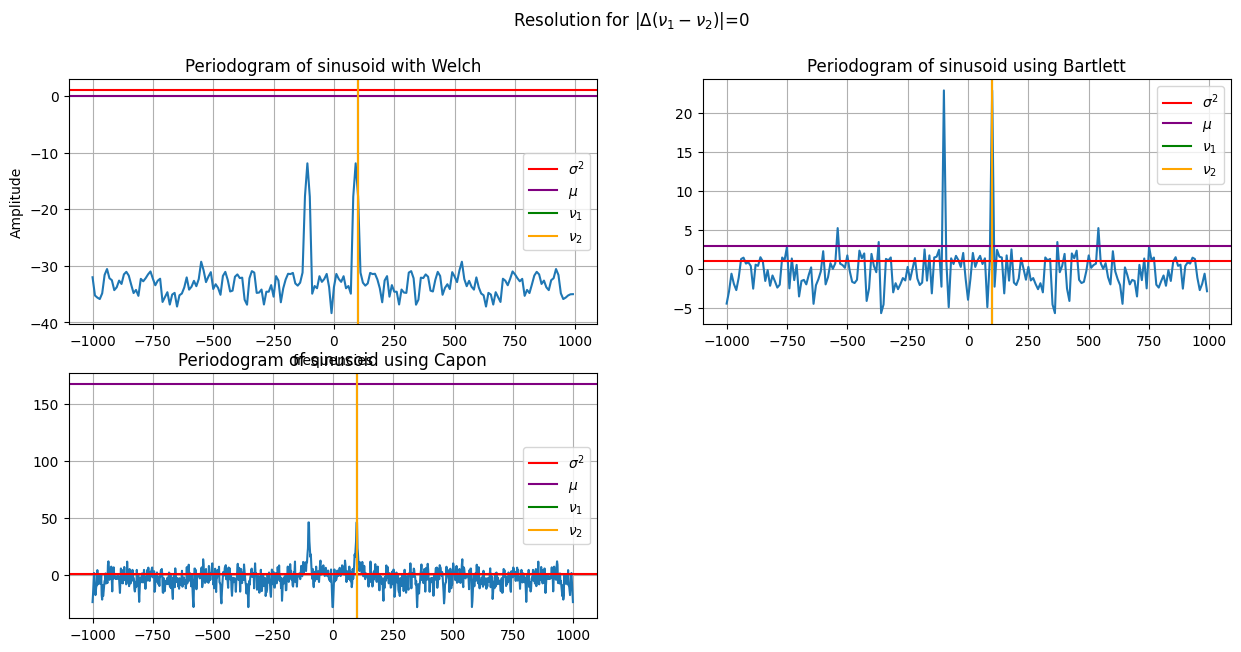

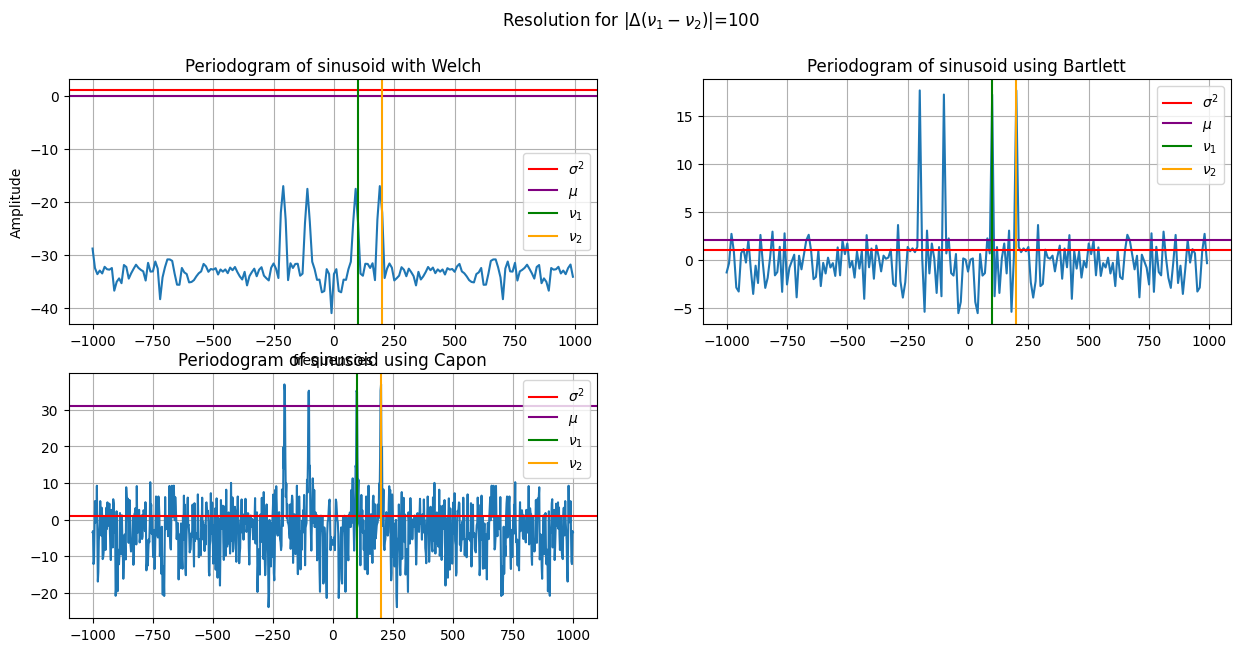

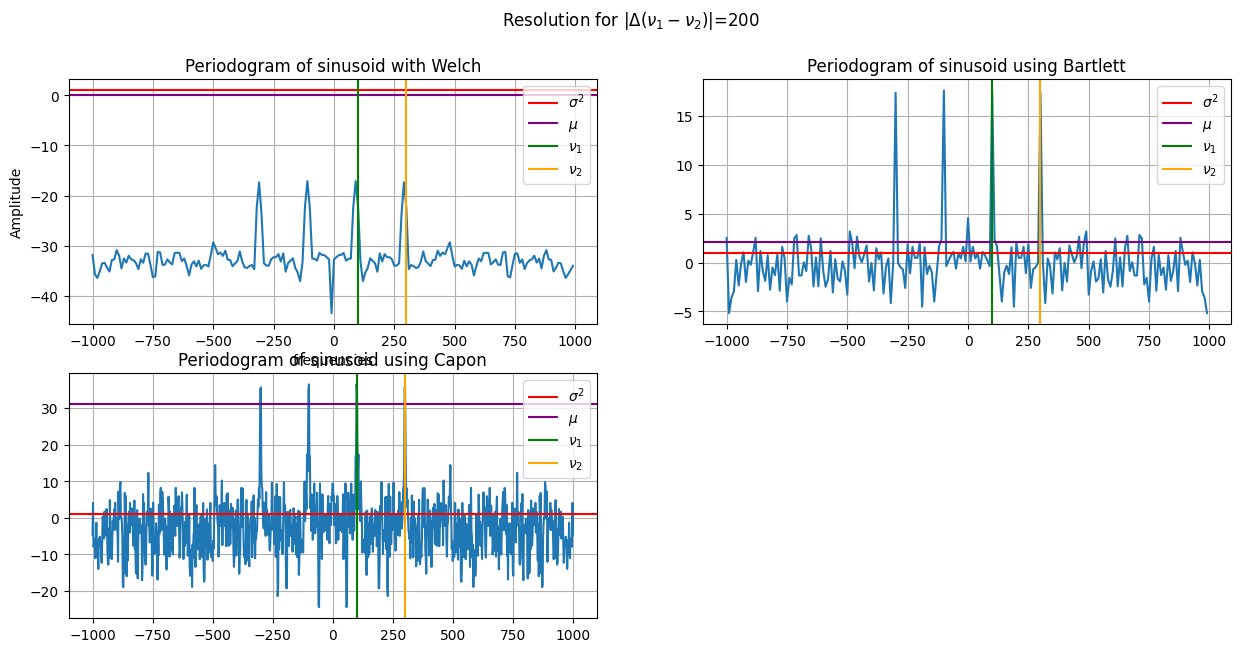

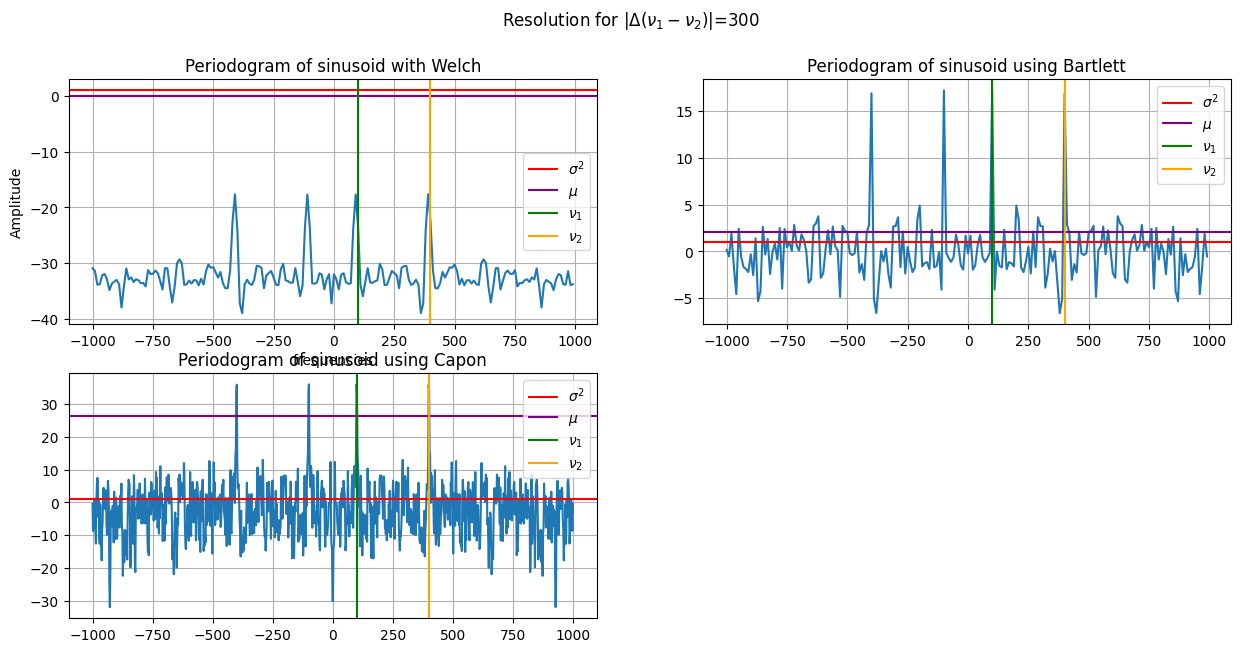

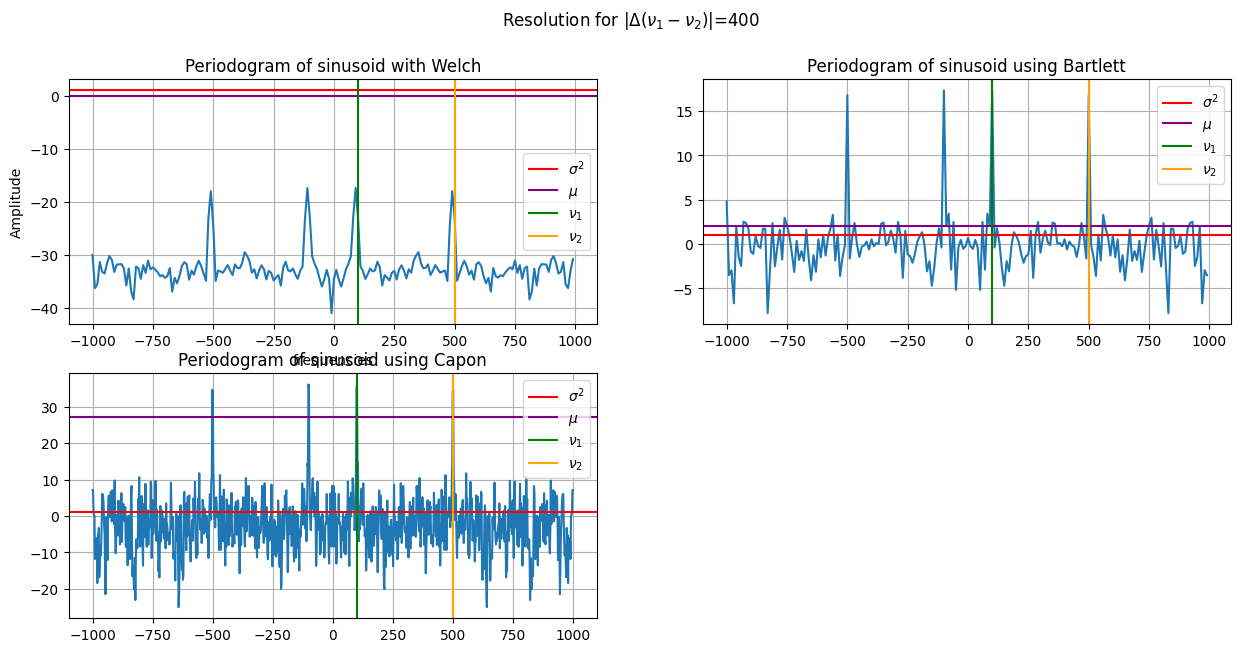

The SNR for |nu_1 - nu_2| = 0 is: 5.0794729109757935
The SNR for |nu_1 - nu_2| = 100 is: 3.5817173324759817
The SNR for |nu_1 - nu_2| = 200 is: 3.645043859505898
The SNR for |nu_1 - nu_2| = 300 is: 3.5451122305052274
The SNR for |nu_1 - nu_2| = 400 is: 3.4414762494354805


In [97]:
# Getting the frequencies, phis, amplitudes, Fs and timesteps
nu_1 = 100 #Hz
nu_2 = np.arange(100, 600, 100) #Hz
Fs = 2 * DEFAULT_NUMBER
amplitudes = [1, 1]
timesteps = np.linspace(0, DEFAULT_NUMBER, DEFAULT_NUMBER)
phases = np.zeros(2)
Z = white_noise(0, SIGMA, DEFAULT_NUMBER)
snr = []

# Plotting the results
for i in nu_2:
    nus_1_2 = [nu_1, i]
    signal_sinousial = sinusoidal(
        amplitudes, nus_1_2, Fs, timesteps, phases, SIGMA
    )
    plotting_sinusoidals_Capon(signal_sinousial, nus_1_2, nu_demi, Fs, SIGMA)
    snr.append(SNR(signal_sinousial, Z))

for j in range(len(nu_2)):
    print(f"The SNR for |nu_1 - nu_2| = {np.abs(nu_2[j] - nu_1)} is: {snr[j]}")

As we can see, the SNR decreases when increasing the gap between the frquencies $\nu$. The resolution of both <strong>Welch and Bartlett</strong> remain the best thanks to their lower variance compared to <strong>Capon</strong> method.

<strong> 3. Autoregressive-moving-average process </strong>  

<strong> 3.1 Synthesis </strong>

1. <ins style="color:orange">Code a function that synthesizes an autoregressive-moving-average (ARMA) process of length N,
defined by its AR and MA coefficients and by the innovation variance σ2. </ins>

The $\text{ARMA}(p,q)$, $(X_{t})_{t \in \mathbb{Z}}$ process is defined as follow:

For $(Z_{t})_{t \in \mathbb{Z}} \sim WN(0, \sigma^2)$

$$\forall t \in \mathbb{Z}, X_t = \sum_{k=1}^p \phi_k X_{t-k} + Z_t + \sum_{k=1}^q \theta_k Z_{t-k}$$

The function down below computes an ARMA process using the previous formula.

In [98]:
def ARMA(p, q, AR_coeff, MA_coeff, sigma, number_variables):
    
    ARAMA_process = np.zeros(number_variables)
    noise = np.random.normal(0, sigma, number_variables + max(p, q))  
    
    for t in range(max(p, q), number_variables):

        ar_term = 0
        for i in range(1, p+1):
            ar_term += AR_coeff[i-1] * ARAMA_process[t - i]

        ma_term = 0 
        for j in range(1, q+1):
            ma_term += MA_coeff[j-1] * noise[t - j]
        
        ARAMA_process[t] = ar_term + ma_term + noise[t]
    
    return ARAMA_process[max(p, q):]  

We define here some constants that we will be using throughout the rest of the Practical Session.

In [99]:
AR_COEFFS = np.array([0.5])
MA_COEFFS = np.array([-0.2])
SIGMA = 1
DEFAULT_NUMBER = 1_000

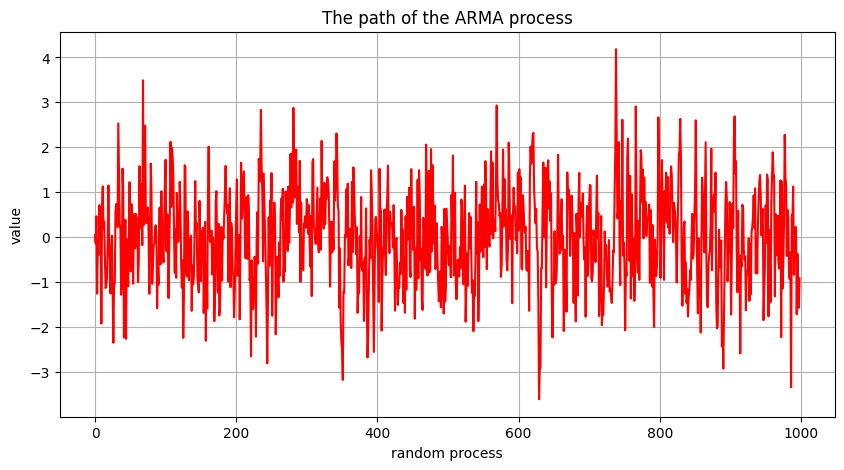

In [100]:
# Computing an ARMA process
ARMA_process = ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, DEFAULT_NUMBER)

# plotting
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(ARMA_process, color="red")
plt.xlabel('random process')
plt.ylabel('value')
plt.title("The path of the ARMA process")
plt.show()

<strong> 3.2 Non-parametric estimation : periodogram </strong>

2. <ins style="color:orange">Display the periodograms obtained with the different methods, in the case of an ARMA process
of order (1, 1) whose parameters can be chosen by hand. We will superimpose in each case the
periodogram with the known PSD of the ARMA process. </ins>

For $(Z_{t})_{t \in \mathbb{Z}} \sim WN(0, \sigma^2)$

$$\forall t \in \mathbb{Z}, X_t = \sum_{k=1}^p \phi_k X_{t-k} + Z_t + \sum_{k=1}^q \theta_k Z_{t-k}$$

Recall that for an ARMA(p,q) process, the power spectral density for a certain $\lambda \in \R$ is :  
$\begin{align}
        f(\lambda) = \sigma^2 \lvert\frac{\Theta}{\Phi}(e^{-2i\pi\lambda})\lvert \nonumber\\ 
\end{align}$
where 
$\begin{align}
        \Phi(X) = 1 + \sum_{k=1}^{p}\phi_{k}X^{k} , \Theta(X) = 1 - \sum_{k=1}^{q}\theta_{k}X^{k} \nonumber
\end{align}$  

The function down below, computes the PSD of an ARMA process.

In [101]:
def psd_ARMA(AR_coeff, MA_coeff, sigma, nu : list):
    """Function to calculate the PSD of an ARMA process
        Optimized to directly use an numpy array of the frequncies of the Signal
    """

    p = len(AR_coeff)
    q = len(MA_coeff)
    
    ar_exp = np.ones((p + 1, len(nu)), dtype=complex)
    ma_exp = np.ones((q + 1, len(nu)), dtype=complex)


    for i in range(1, p+1):
        ar_exp[i, :] = -(AR_coeff[i-1] * np.exp(-2j * np.pi * i * nu))

    for j in range(1, q+1):
        ma_exp[j, :] = MA_coeff[j-1] * np.exp(-2j * np.pi * j * nu)
 
    ma_exp = np.sum(ma_exp, axis = 0)
    ar_exp = np.sum(ar_exp, axis = 0)
 
    ma_exp = pow(np.abs(ma_exp), 2)
    ar_exp = pow(np.abs(ar_exp), 2)
 
    return pow(sigma, 2) * (ma_exp / ar_exp)

Let us now plot the different periodograms of the $\text{ARMA}(p,q)$ process using the different Methods and we will be comparing them to the theoretical PSD.

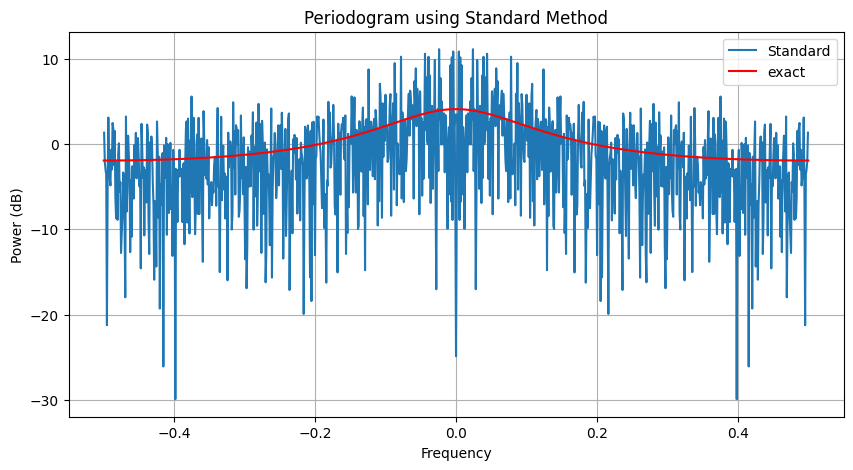

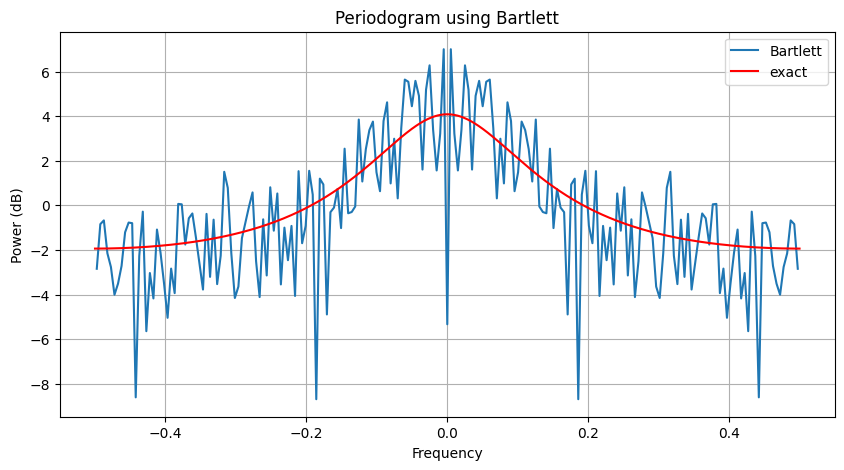

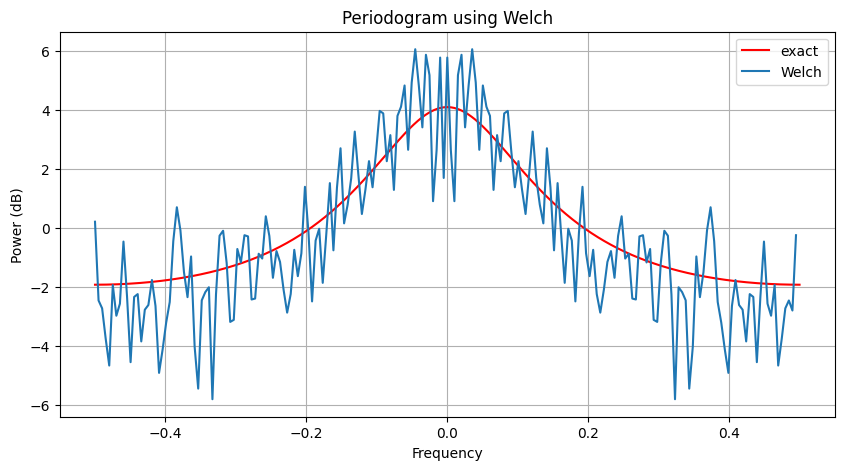

In [102]:
# Plotting the PSD and periodograms for different Methods
f_arma_sandard, standard_ARMA = periodogram(ARMA_process)
f_arma_bartlett, bartlett_ARMA = periodogram(ARMA_process, method="Bartlett")
f_arma_welch , welch_ARMA = periodogram(ARMA_process, method="Welch")
psd_arma = psd_ARMA(AR_COEFFS, MA_COEFFS, SIGMA, nu_demi)


# Plotting the Graph
plt.figure(figsize=(10,5))
plt.plot(f_arma_sandard, 10*np.log10(standard_ARMA), label="Standard")
plt.plot(nu_demi, 10*np.log10(psd_arma), label="exact",color='red')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Standard Method")
plt.grid()

plt.figure(figsize=(10,5))
plt.plot(f_arma_bartlett, 10*np.log10(bartlett_ARMA), label="Bartlett")
plt.plot(nu_demi, 10*np.log10(psd_arma), label="exact", color='red')
plt.grid()
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Bartlett")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(nu_demi, 10*np.log10(psd_arma), label="exact",color='red')
plt.plot(f_arma_welch, 10*np.log10(welch_ARMA), label="Welch")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Welch")
plt.grid()
plt.show()


3. <ins style="color : orange"> Compare these different estimators in terms of bias and variance. </ins>

Just like before, we define a function that calculates the means and the Variances of the different estimators.

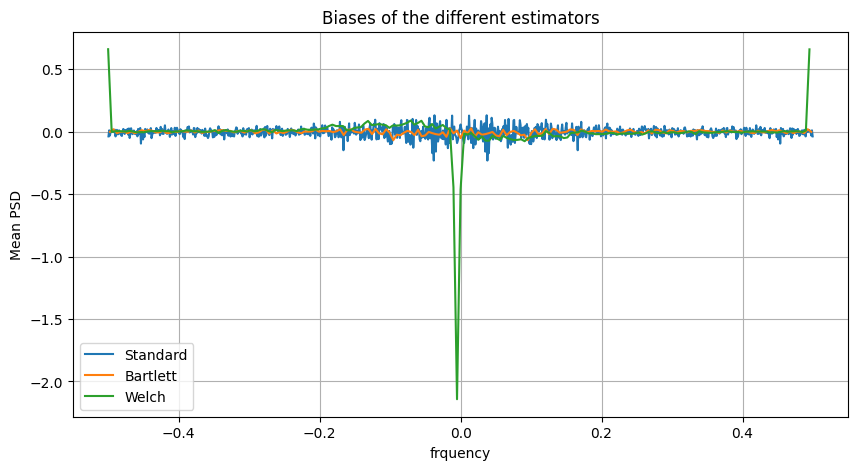

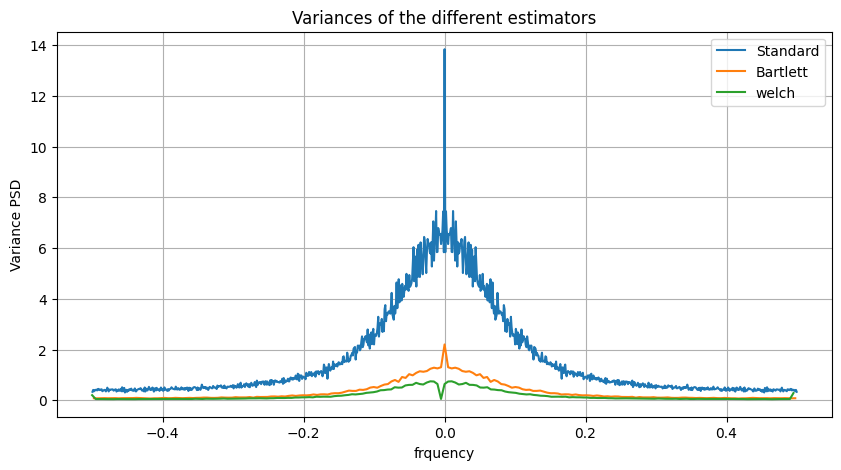

In [103]:
def bias_var_calculator_ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables, method):
    """ Bias and Variance Caluclator for the periodogram of an AR process"""
    
    number_tests = DEFAULT_NUMBER
    ARMA_process = ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables)
    f, _ = periodogram(ARMA_process, method=method)
    periodogram_list = np.zeros((numebr_variables, len(f)))
    theoritical_spectral = psd_ARMA(AR_coeffs, MA_coeffs, sigma, f)

    for i in range(number_tests):
        ARMA_process = ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables)
        _, periodogram_inter = periodogram(ARMA_process, method=method)
        periodogram_list[i, :] = periodogram_inter

    mean_process = np.mean(periodogram_list, axis=0)
    bias_process = mean_process - theoritical_spectral
    var_process = np.var(periodogram_list, axis=0)
    
    return mean_process, bias_process, var_process


_, bias_standard_arma, var_standard_arma = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, DEFAULT_NUMBER, method="Standard")
_,bias_barlett_arma, var_barlett_arma = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, DEFAULT_NUMBER, method="Bartlett")
_,bias_welch_arma, var_welch_arma = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, DEFAULT_NUMBER, method="Welch")


plt.figure(figsize=(10,5))
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f_arma_sandard, bias_standard_arma, label="Standard")
plt.plot(f_arma_bartlett, bias_barlett_arma, label="Bartlett")
plt.plot(f_arma_welch, bias_welch_arma, label = "Welch")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f_arma_sandard, var_standard_arma, label="Standard")
plt.plot(f_arma_bartlett, var_barlett_arma, label="Bartlett")
plt.plot(f_arma_welch, var_welch_arma, label="welch")
plt.legend()
plt.show()

Just like before, the <strong> Welch and Bartlett</strong> estimators have minimal variance compared to the <strong>Standard</strong> estimator. The estimators have the same bias.

<strong> 3.3 Parametric estimation : Durbin method</strong>

4.<ins style="color : orange"> Code a function that implements the Durbin method (estimation of the AR part by shifting the
autocorrelation, estimation of the MA part via a long AR). </ins>

### Estimation of the AR part of the process.

$$ \mathbb{E}[X_{t-n} Z_{t-q}] = 0 \quad \forall n > q \quad \Rightarrow \quad \begin{bmatrix} r_{XX}(q+1) \\ \vdots \\ r_{XX}(q+p) \end{bmatrix} = \begin{bmatrix} r_{XX}(q) & r_{XX}(q-1) & \cdots & r_{XX}(q-p+1) \\ r_{XX}(q+1) & \cdots & \cdots & \vdots \\ \vdots & \cdots & r_{XX}(q+1) & r_{XX}(q-1) \\ r_{XX}(q+p-1) & \cdots & r_{XX}(q+1) & r_{XX}(q) \end{bmatrix} \begin{bmatrix} a_1 \\ \vdots \\ a_p \end{bmatrix} $$

The function down below is an implementation of the approximation of the AR part.

In [104]:
def estimate_AR_of_ARMA(p, q, signal):
    """ Estimate AR(p) coefficients of an ARMA(p, q) process using Modified Yule-Walker. """
    
    max_lag = q + p 
    taus = np.arange(max_lag+1)
    autocov = empirical_autocovariance(signal, taus)
    r_xx_rhs = autocov[q+1:q+p+1]
    # Toepliz Matrix
    gamma = np.array([autocov[q + i - j] for i in range(p) for j in range(p)]).reshape((p, p))

    # Coefficients using the inverse
    a_coeffs = np.linalg.solve(gamma, r_xx_rhs)
    
    return a_coeffs

### Estimation of the MA part of the process

**Let**  
  $$ Y_t = X_t - a_1 X_{t-1} - \dots - a_p X_{t-p} = b_0 Z_t + b_1 Z_{t-1} + \dots + b_q Z_{t-q} $$

$$ r_{YY}(k) = \begin{cases} 
  \sigma_Z^2 (b_0 b_k + b_1 b_{k+1} + \dots + b_{q-k} b_q) & \text{if } k \leq q \\
  0 & \text{if } k > q 
  \end{cases} $$

$$ S_{YY}(\nu) = S_{XX}(\nu) |A(e^{2i\pi \nu})|^2 = \sum_{k=-q}^{q} r_{YY}(k) e^{-2i\pi \nu k} $$

**First ARMA PSD estimate:**  
  $$ \hat{S}_{XX}(\nu) = \sum_{k=-q}^{q} \hat{r}_{YY}(k) e^{-2i\pi \nu k} \frac{1}{|A(e^{2i\pi \nu})|^2} $$

**Problem:** the numerator is not necessarily non-negative

### Solution : Estimation of the MA part: Durbin method

- **Let** $ \hat{r}_{YY}(k) $. We want to find $ \hat{b}_0, \dots, \hat{b}_q, \hat{\sigma}_Z^2 $ such that  
  $$ S_{YY}(\nu) = \hat{\sigma}_Z^2 |\hat{B}(e^{2i\pi \nu})|^2 $$

- Solve Yule-Walker equations to find an AR(L) on the $ \hat{r}_{YY}(k) $ for $ k = 0 \dots L \gg q $  
  $$ \rightarrow [\hat{a}_1, \dots, \hat{a}_L] \text{ such that } S_{YY}(\nu) = \frac{\sigma_1^2}{|\hat{A}_L(e^{2i\pi \nu})|^2} \text{ then let } \hat{r}(k) \text{ be the sequence such that } |\hat{A}_L(e^{2i\pi \nu})|^2 = \sum_{k=-L}^{L} \hat{r}(k) e^{-2i\pi \nu k} $$

- On the $ \hat{r}(k) $, estimate an AR(q) by solving Yule-Walker equations  
  $$ \rightarrow [\hat{b}_1, \dots, \hat{b}_q] \text{ such that } |\hat{A}_q(e^{2i\pi \nu})|^2 = \frac{\sigma_2^2}{|\hat{B}(e^{2i\pi \nu})|^2} \text{ with } \hat{B}(z) = 1 + \sum_{n=1}^{q} \hat{b}_n z^{-n}, \text{ hence } $$  
  $$ S_{YY}(\nu) = \frac{\sigma_1^2}{|\hat{A}_L(e^{2i\pi \nu})|^2} = \frac{\sigma_2^2}{|\hat{B}(e^{2i\pi \nu})|^2} $$

- **ARMA PSD estimate:**  
  $$ \hat{S}_{XX}(\nu) = \hat{\sigma}_Z^2 \frac{|\hat{B}(e^{2i\pi \nu})|^2}{|A(e^{2i\pi \nu})|^2} \text{ with } \hat{\sigma}_Z^2 = \frac{\sigma_1^2}{\sigma_2^2} $$

First, let us define the Yule-Walker function that will give the approximation of the coefficients, this is different than the preciously defined Gamma function, as in this one is for the $\text{ARMA}$ process.

In [105]:
def yule_walker(autocov, order):
    """ Solving the Yule-Walker equation using """

    # Toeplitz
    gamma = sp.linalg.toeplitz(autocov)
    approximation = np.linalg.inv(gamma) @ np.array([1 if v == 0 else 0 for v in range(order+1)]).T
    
    # Getting sigma and phis
    sigma_approximation_square = 1/approximation[0]
    empirical_phis = -(sigma_approximation_square*approximation[1:])
    sigma_approximation = np.sqrt(sigma_approximation_square)

    # Getting results
    return empirical_phis, sigma_approximation

Now for the long part, the function down below defines the <strong>Durbin</strong> method, it returns the estimated PSD and the estimated parameters of the ARMA process.

In [106]:
def durbin(p, q, L, signal, nus):
    """Computes the PSD estimate using the Durbin Method as per the slide."""
    
    # Estimating AR part
    AR_estimate = estimate_AR_of_ARMA(p, q, signal)
    
    # Getting Y_t, ie we filter the AR part of the signal
    signal_inter = np.zeros(len(signal))
    for i in range(p, len(signal)):
        signal_inter[i] = signal[i] - np.sum([
            AR_estimate[j-1] * signal[i-j] for j in range(1, p+1)
        ])
    signal = signal_inter[p:]  
    
    # Application of the Durbin method
    taus = np.arange(0, L + 1)
    r_YhatYhat = empirical_autocovariance(signal, taus)
    
    # Getting 1/|A(nu)|
    AR_L, sigma_1 = yule_walker(r_YhatYhat, L)
    A_L = np.concatenate(([1], -np.array(AR_L)))  

    # This is difficult to explain, but we will be padding the signal to get the same lenght as the frquencies
    fft_len = len(nus)  
    A_L_padded = np.pad(A_L, (0, fft_len - len(A_L)), 'constant') 
    A_L_freq = np.fft.fft(A_L_padded)
    S_YhatYhat = sigma_1**2 / (np.abs(A_L_freq)**2)
    
    # Getting the coefficients of 1/|A(nu)|
    r_hat = np.real(np.fft.ifft(S_YhatYhat))[:q+1] 
    
    # Getting the MA part of the signal, using Yule Walker Again !
    MA_coeffs, sigma_2 = yule_walker(r_hat, q)

    # Approximating the PSD
    psd = psd_ARMA(AR_estimate, MA_coeffs, sigma_2 / sigma_1, nus)
    
    # printing the results
    return psd, AR_estimate, MA_coeffs, sigma_2 / sigma_1

5. <ins style="color : orange"> Superimpose the spectral envelope of the estimated ARMA model with that of the exact ARMA
model and with the periodogram. Comment. </ins>

The durbin method imposes $L >> q$, so we can take $L = 500$, we will also change the coefficients and the order to make our ARMA process more complex.

In [107]:
L = 500
AR_COEFFS = [0.4, 0.1, 0.2] # p = 4
MA_COEFFS = [-0.5, 0.7, 0.4, 0.8] # q = 4
SIGMA = 1
ARMA_process = ARMA(3, 4, AR_COEFFS, MA_COEFFS, SIGMA, DEFAULT_NUMBER)

The estimated AR coefficients are: [0.43333268 0.06459702 0.18551311].
The estimated MA coefficients are: [-0.142035    0.34861227  0.10776997  0.18216811].
The estimated sigma is: 1.2700935002467748


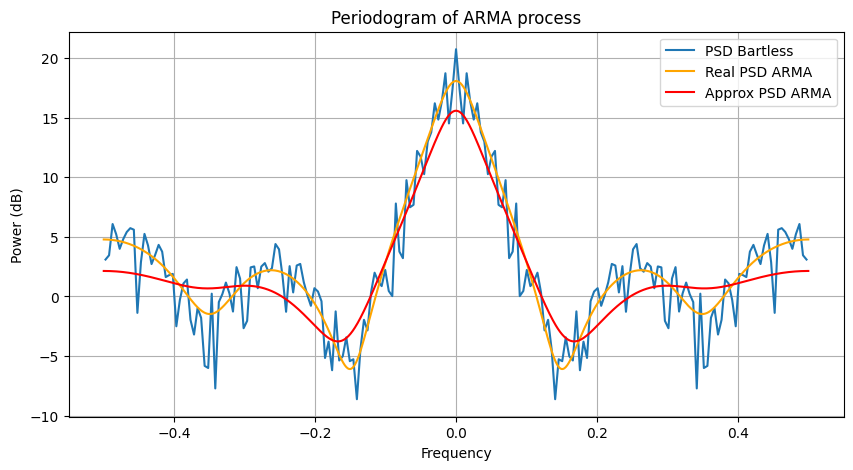

In [108]:
# Getting the PSDs
psd_estimate, AR_estimate, MA_coeffs, sigma_estimate = durbin(3, 4, L, ARMA_process, nu_demi)
psd_arma = psd_ARMA(AR_COEFFS, MA_COEFFS, SIGMA, nu_demi)
f_bartlett, bartlett_ARMA = periodogram(ARMA_process, method="Bartlett")
print(f"The estimated AR coefficients are: {AR_estimate}.\nThe estimated MA coefficients are: {MA_coeffs}.\nThe estimated sigma is: {sigma_estimate}")

# Plotting the results
plt.figure(figsize=(10,5))

plt.title("Periodogram of ARMA process")
plt.plot(f_bartlett, 10*np.log10(bartlett_ARMA), label="PSD Bartless")
plt.plot(nu_demi, 10*np.log10(psd_arma), color='orange', label="Real PSD ARMA")
plt.plot(nu_demi, 10*np.log10(psd_estimate), color='red', label="Approx PSD ARMA")
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.legend()
plt.grid()

plt.show()

We can see that the approximated $\text{MA}$ coefficients do not match the real ones at all! However, the PSD closely matches the real one! The Durbin Method then has some errors, but the approximated PSD is acceptable.

<strong> 3.4 Application to speech signals </strong>  

6. <ins style="color : orange">Apply the above methods to a nasal vowel sound (such as ’in’ for example, that we will be able
to extract from file an_in_on.wav, downloadable on the eCampus website of TSIA202b), and
superimpose the estimated spectra. </ins>

First we are going to extract the 'in' sound of the soundfile.

In [109]:
x_aninon, sr = librosa.load("an_in_on.wav", sr=None)

# 'IN' sound
start_time = 0.2
end_time = 0.8

end_sample = int(end_time * sr)
start_sample = int(start_time * sr)
x_aninon_sampled = x_aninon[start_sample : end_sample]

# Approximating the ARMA signal
f_bartlett, bartlett_ARMA = periodogram(x_aninon_sampled, method="Bartlett")

We will now try estimating the 'in' sound using the <strong>Durbin</strong> mehtod. We will change the values of both $p$ and $q$ and conclude the influence of these parameters.

In [110]:
# Defining the p and q that we will use to estimate the sound
p_list = [1, 5, 10, 50]
q_list = [1, 5, 10, 50]

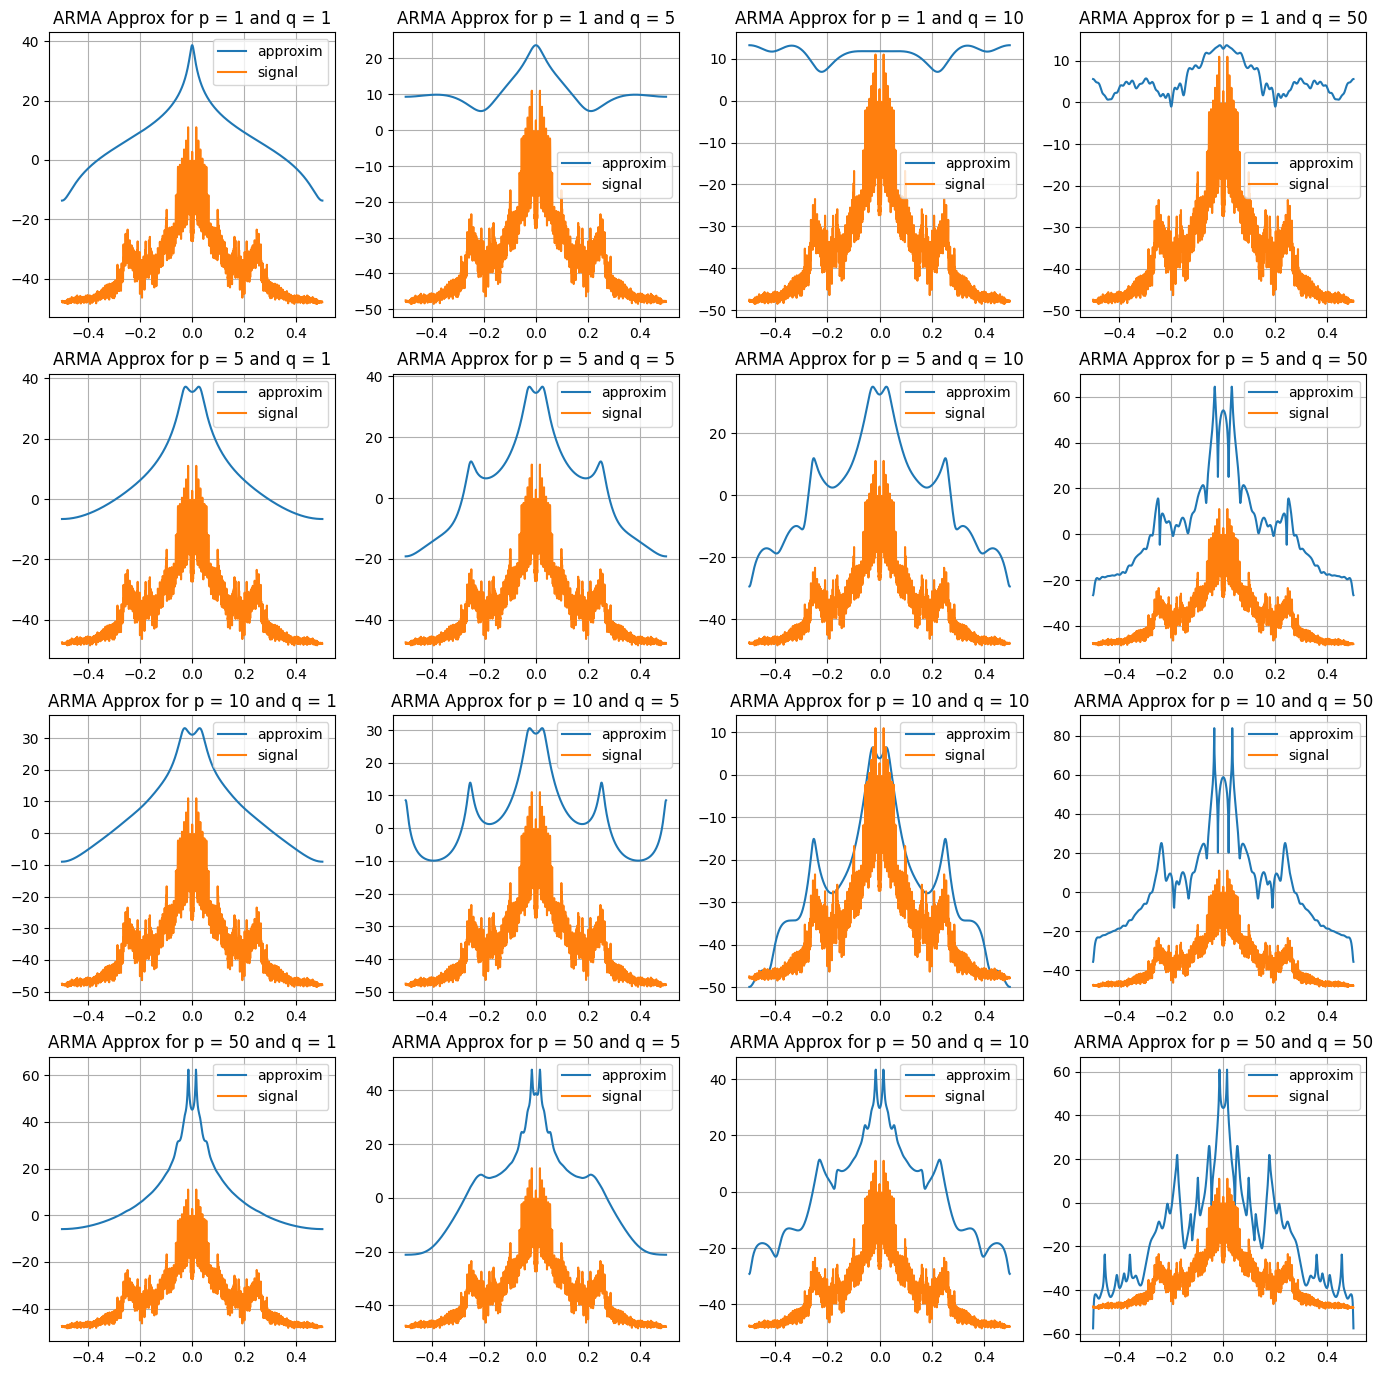

In [111]:
fig, ax = plt.subplots(4, 4, figsize=(17, 17))
for p in range(len(p_list)):
    for q in range(len(q_list)):
        psd_ARMA_anion, AR_estimate, MA_estimate, _ = durbin(p_list[p], q_list[q], L, x_aninon_sampled, nu_demi)
        ax[p,q].plot(nu_demi, 10*np.log10(psd_ARMA_anion), label="approxim")
        ax[p,q].plot(f_bartlett, 10*np.log10(bartlett_ARMA), label="signal")
        ax[p,q].legend()
        ax[p,q].grid()
        ax[p,q].set_title(f"ARMA Approx for p = {p_list[p]} and q = {q_list[q]}")

plt.show()

What do we notice ? the $p$ value controls the envelop of the signal, it basically determines the global shape of the signal. The $q$ value determines the fluctuations of the reconstructed signal, the details of the reconstruction.

It is no surprise that the $p=50$ and $q=50$ is the best reconstruction, both for the envelop and the details of the reconstructed signal.